# Credit Card Fraud Detection
This project is initiated to analyze anonimized dataset provided by **Machine Learning Group - ULB** at Kaggle [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since the data is anonymized and doesn't describe time-related relation between each data, we will disregard time series analysis. So, in this project, the data will be analyzed (disregarding time series) to create a model using:
- Artificial Neural Network

### Import Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from matplotlib.gridspec import GridSpec

### Initiate Setup

In [85]:
%matplotlib inline
np.seed = 0

evaluation_portion = 0.2
outlier_percentile = 0.05
dataset_location = './data/creditcard.csv'

### Load Data
Let's load the data using `pandas` to ease our work.

In [86]:
data = pd.read_csv(dataset_location)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Since the data contains class, we will create model using classification algorithm. But, before we do that, in this project we will split the data into two parts based on portion. The part with higher portion will be treated as *data set* while the other is treated as *data evaluation*. Let's set the portion to be 80% for data set and 20% for data evaluation.

In [92]:
data_set, data_evaluation = train_test_split(data, test_size = evaluation_portion)

### Draw Figure

Now that we have split the data, let's put *data evaluation* aside and focus on *data set*.<br>
In order to help us understand the "shape" of data we have, let's create figure representing data from each feature. Since we have two classes, let's separate them and draw the figure side by side.

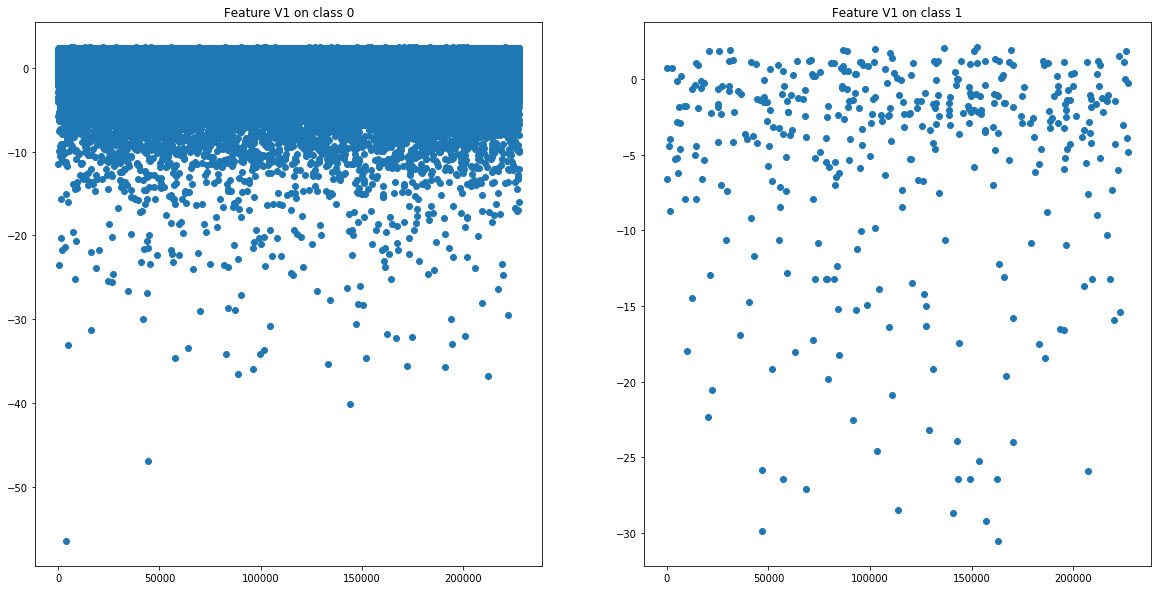

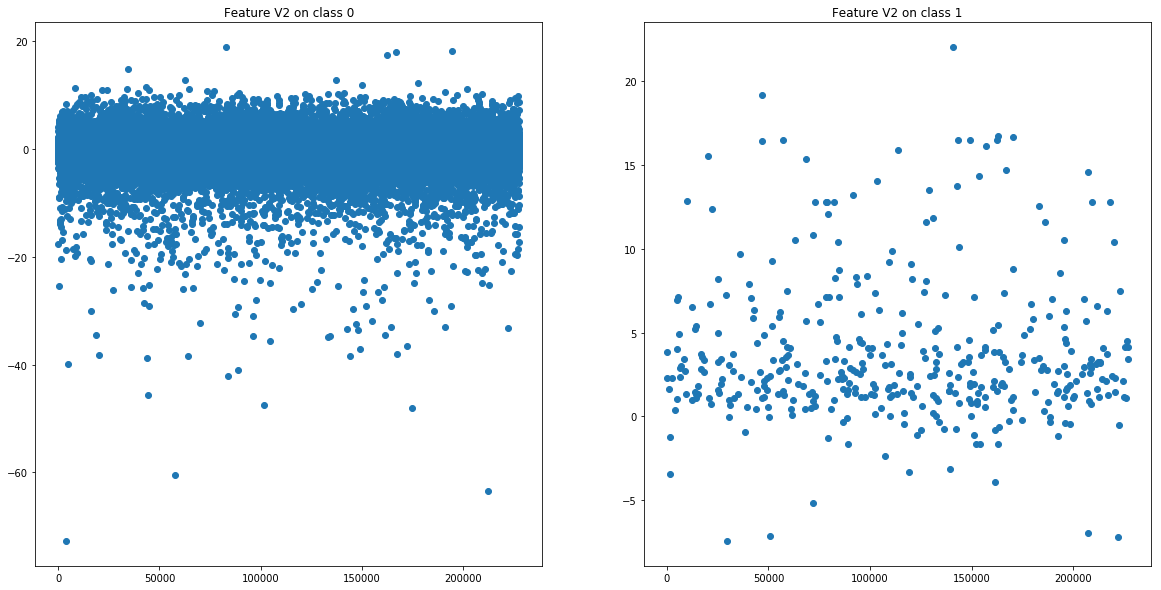

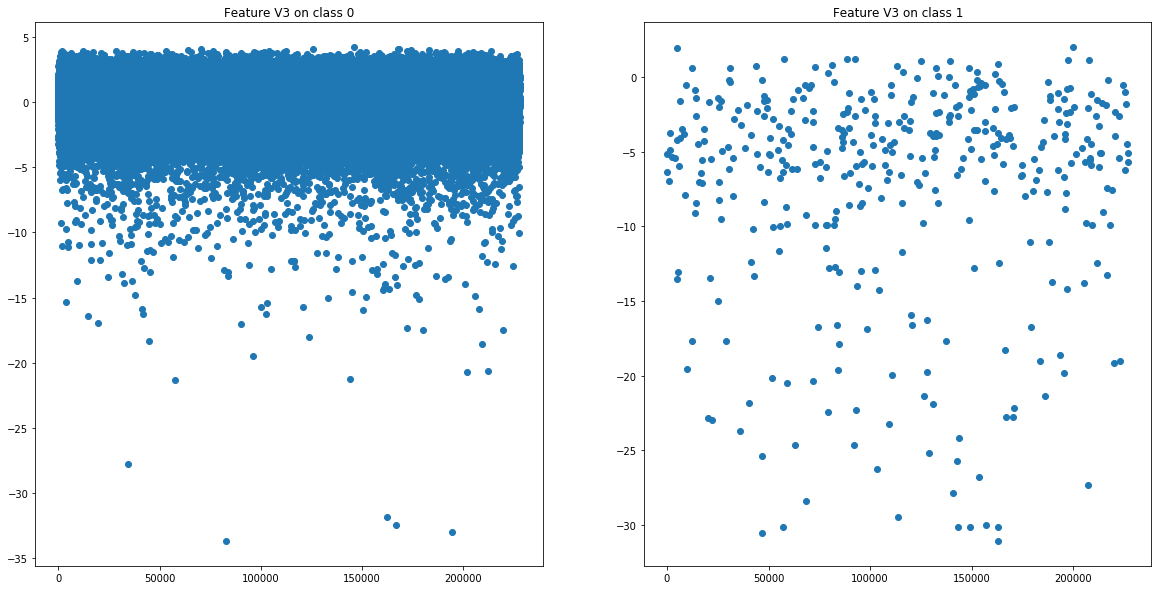

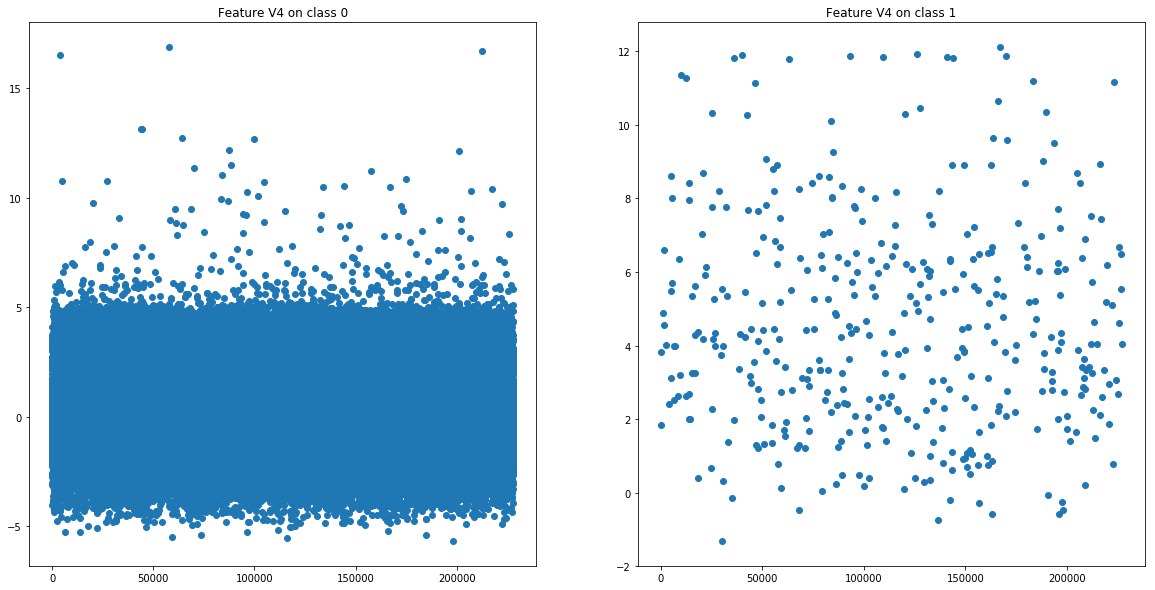

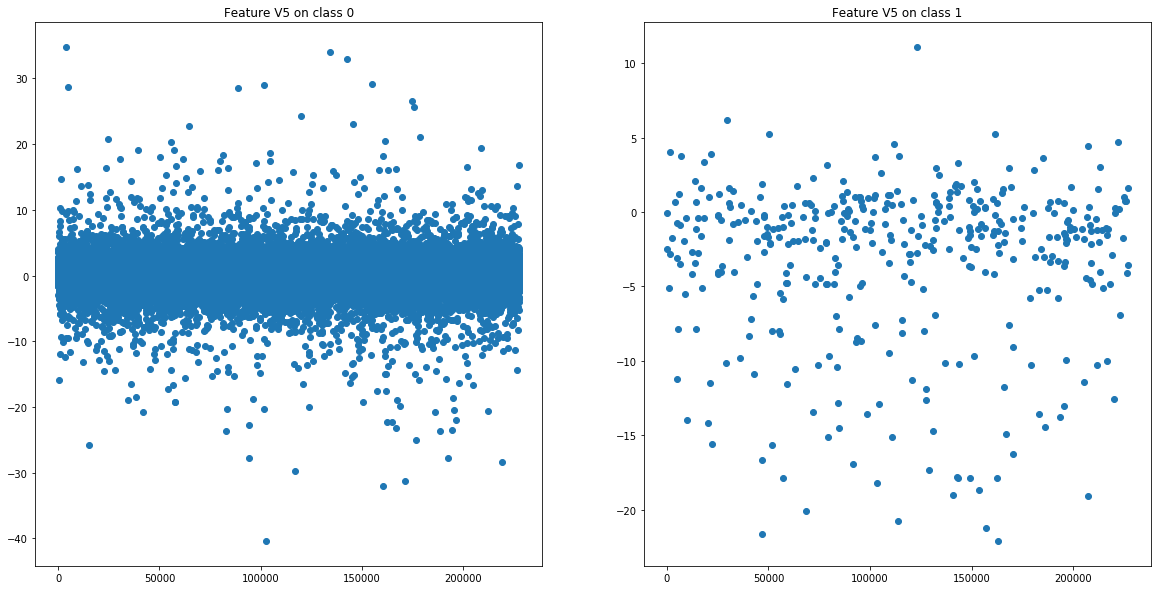

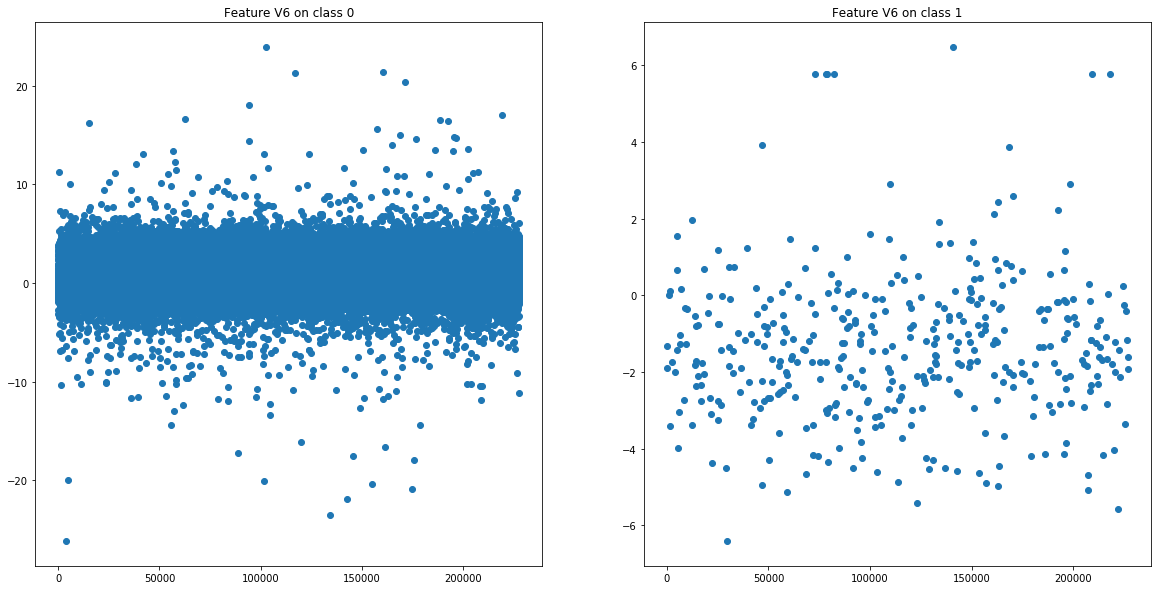

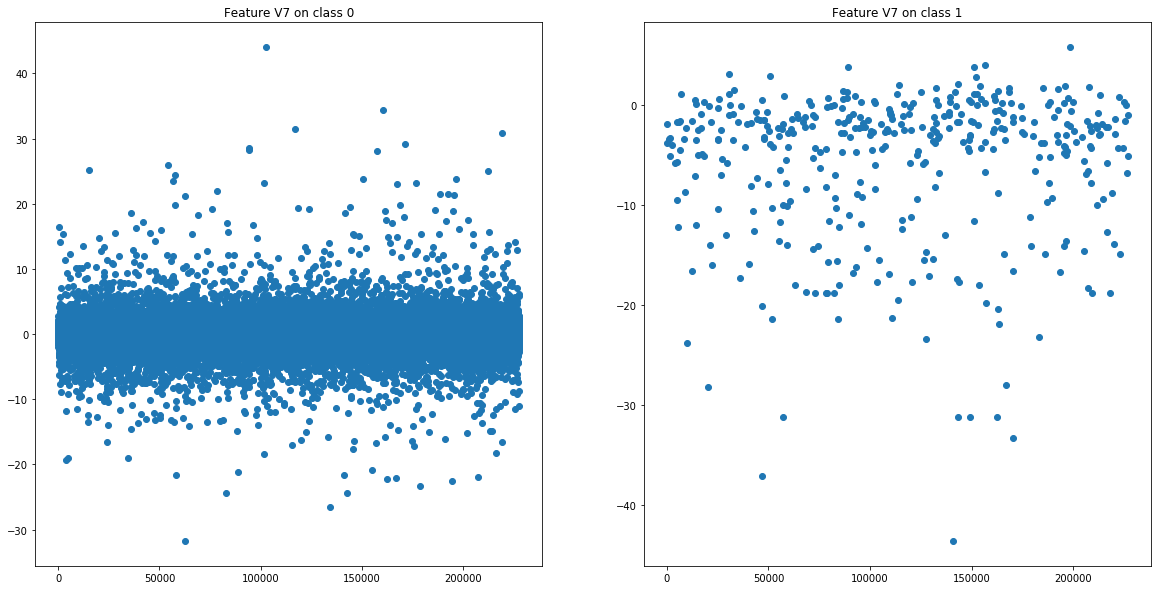

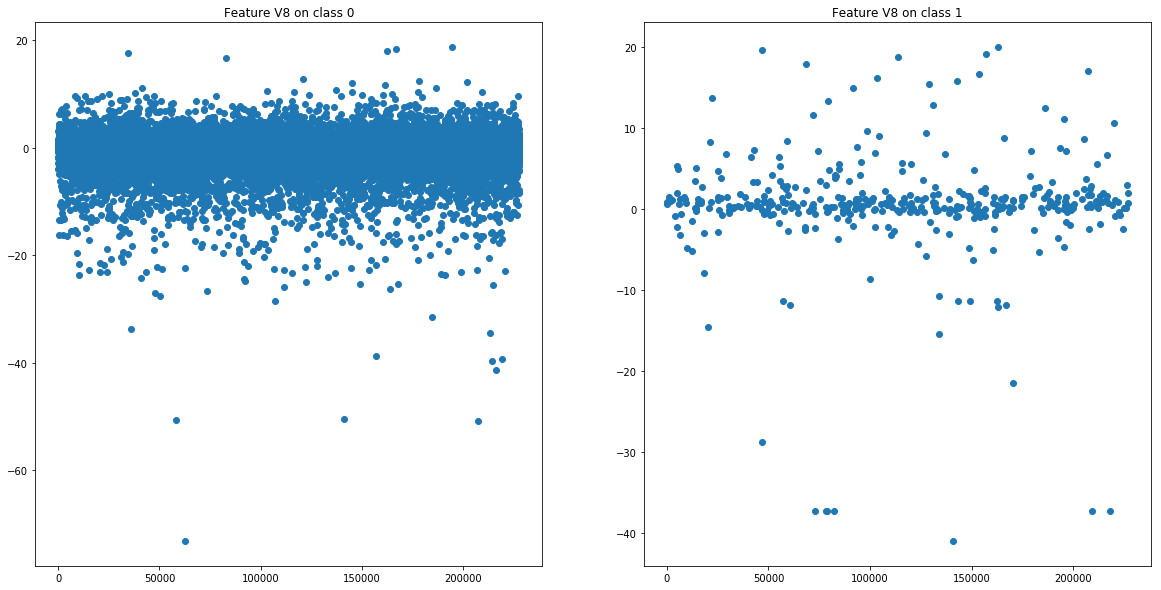

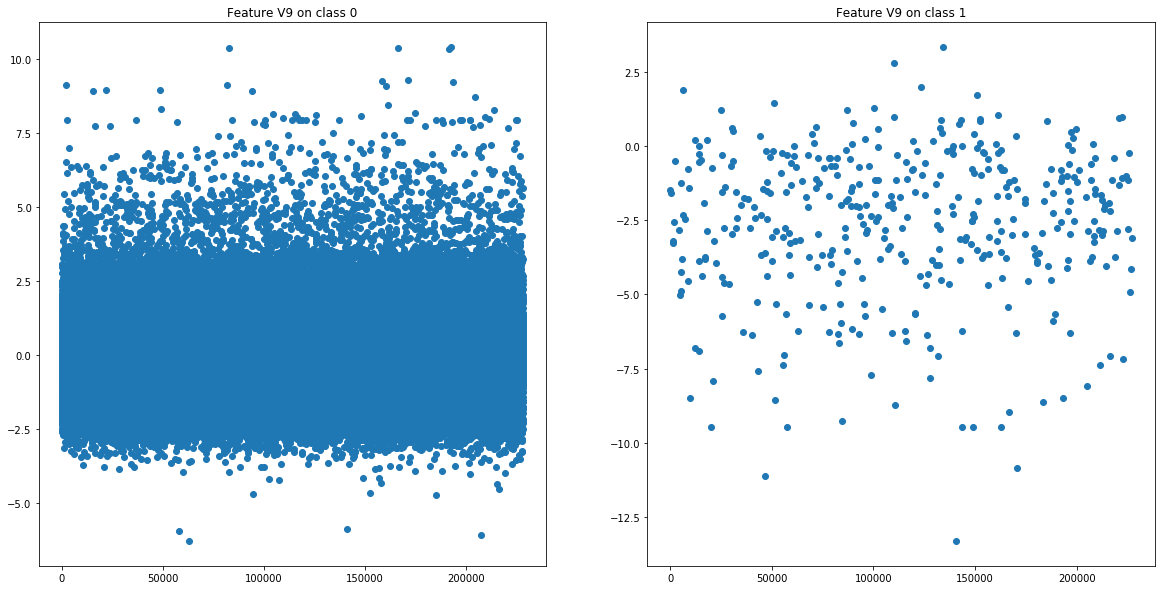

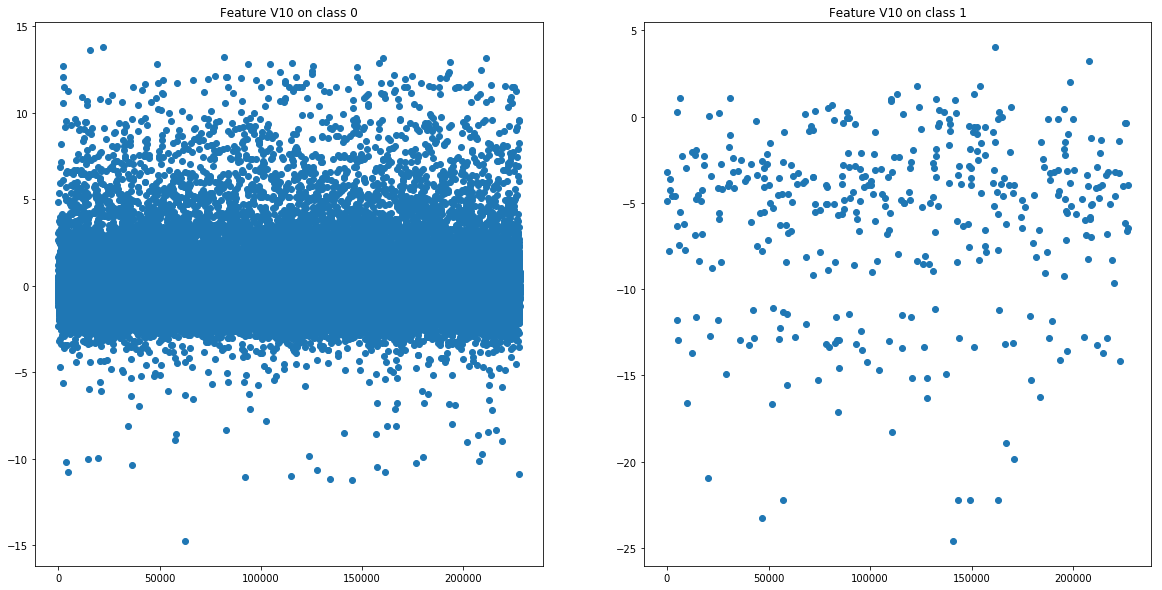

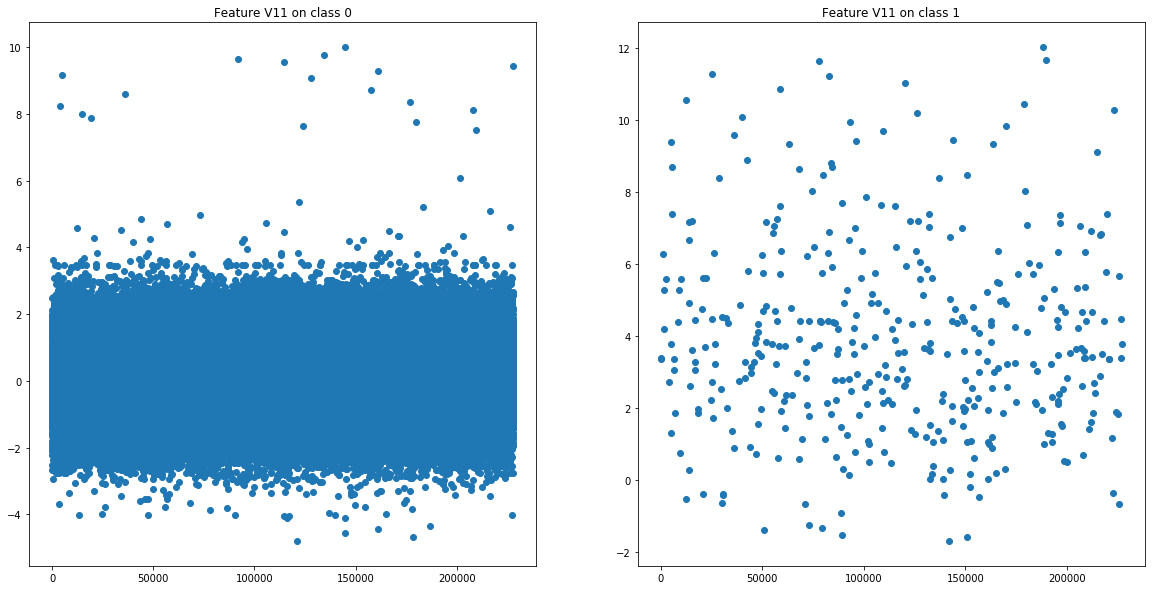

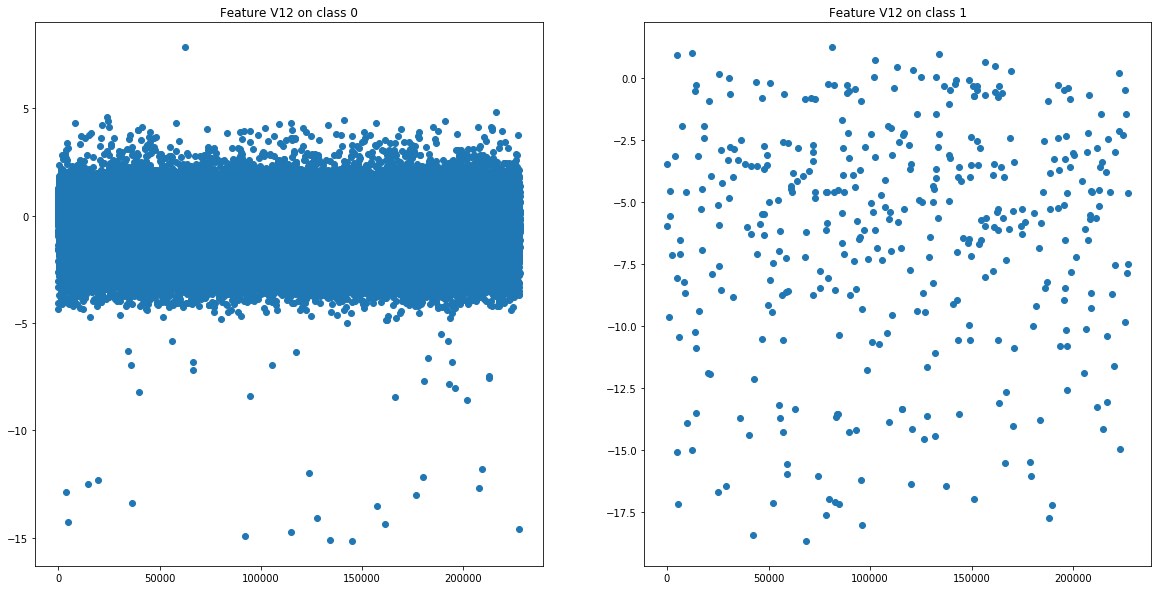

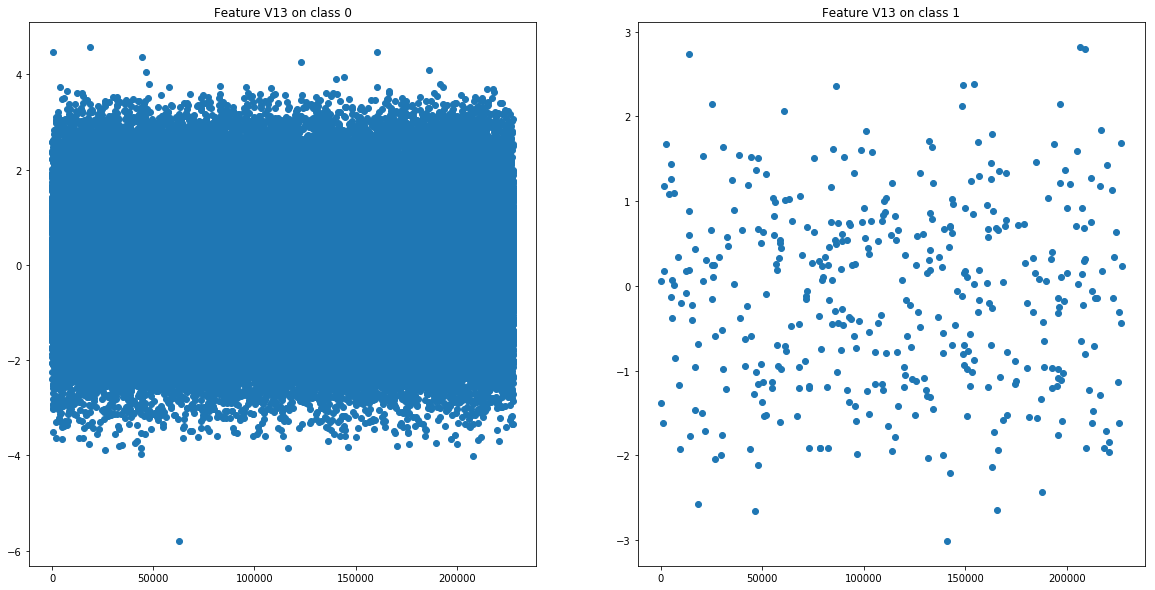

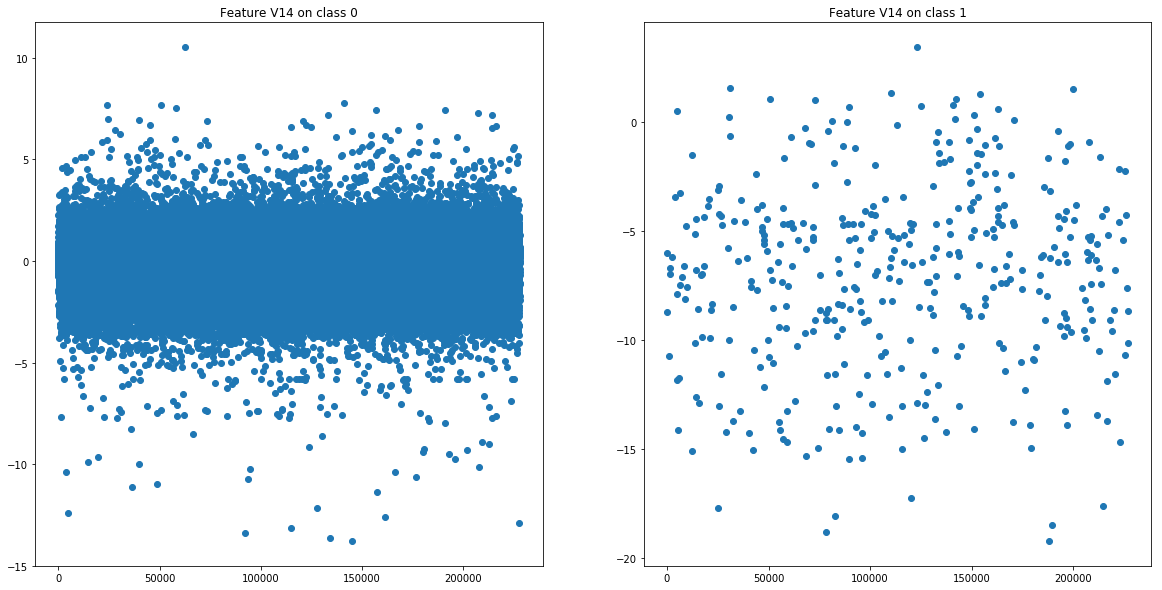

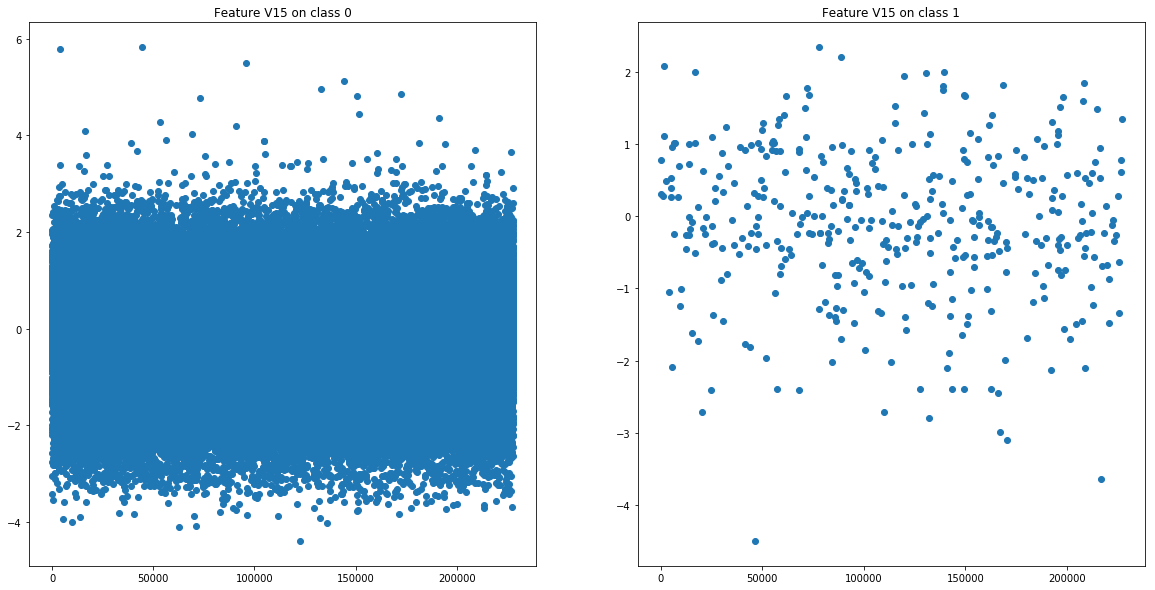

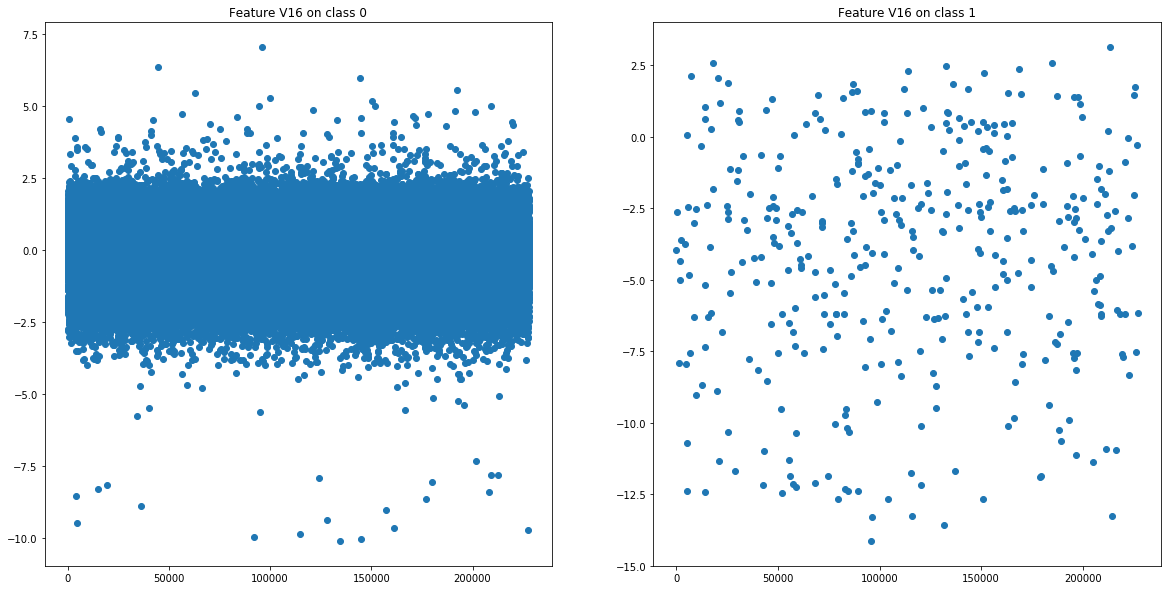

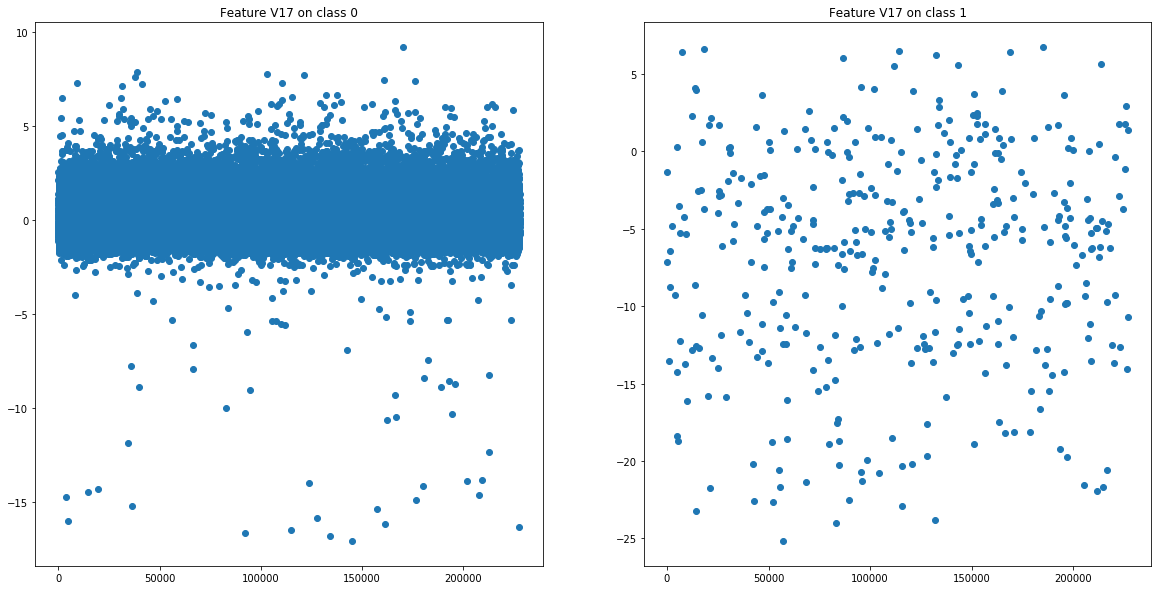

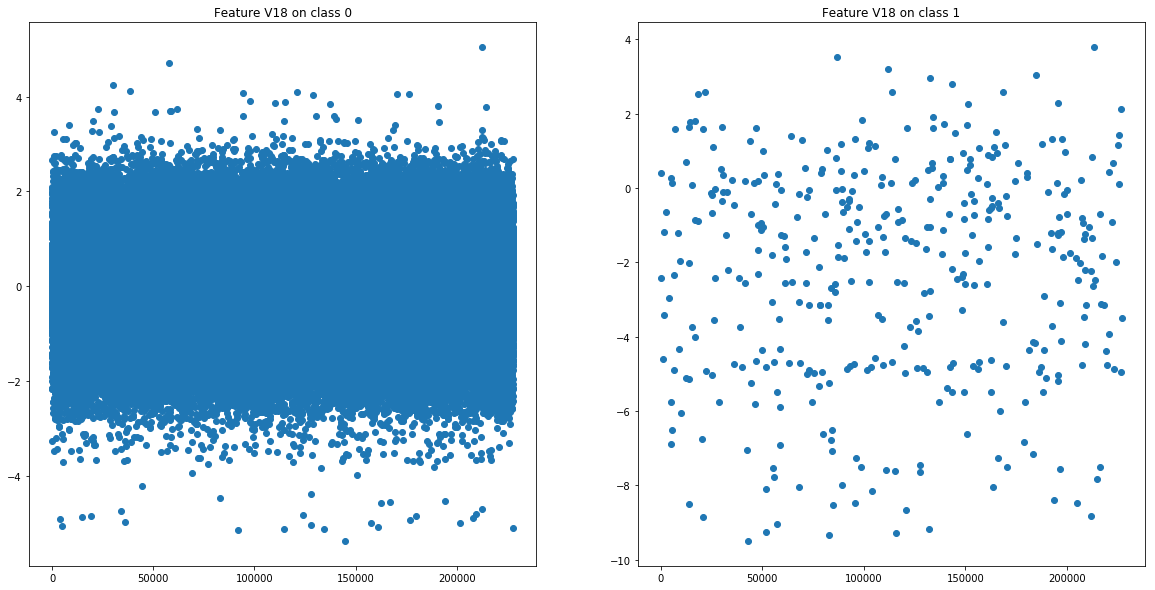

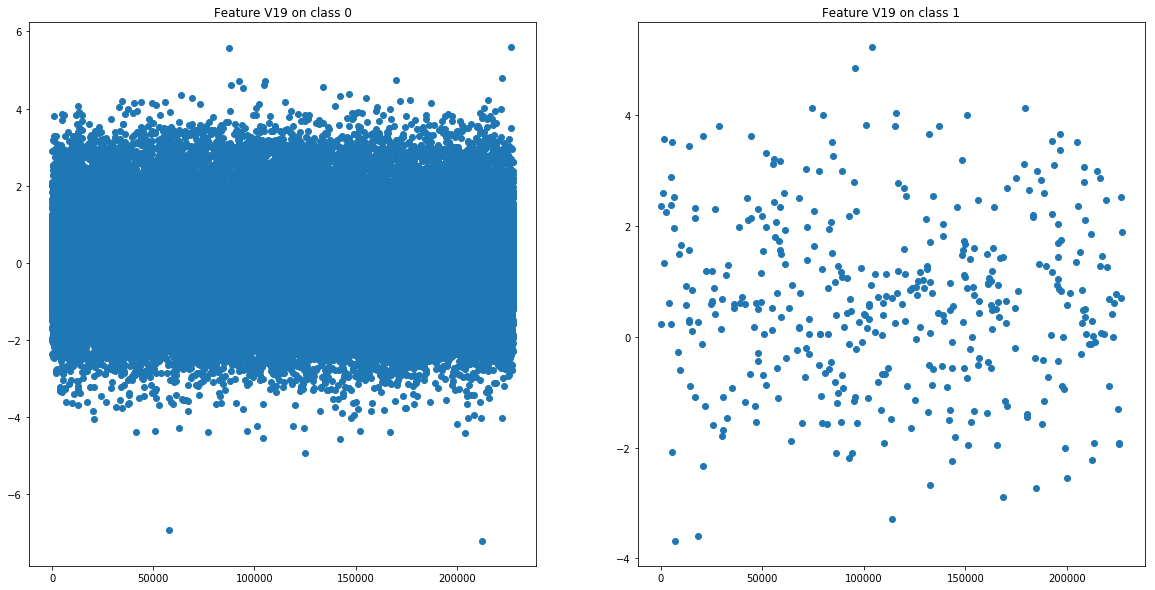

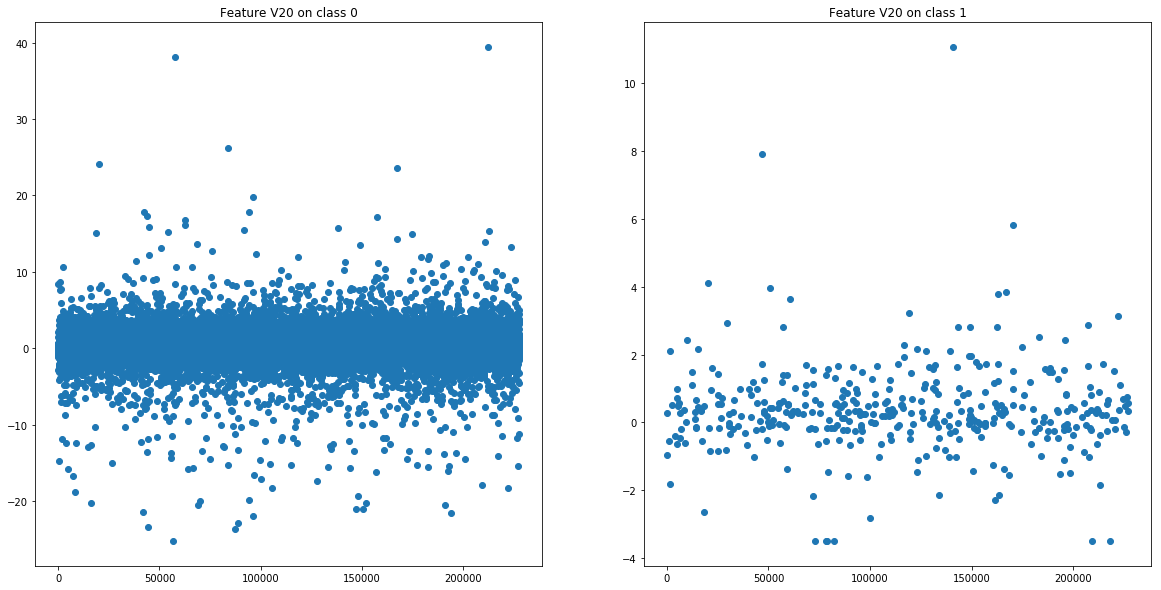

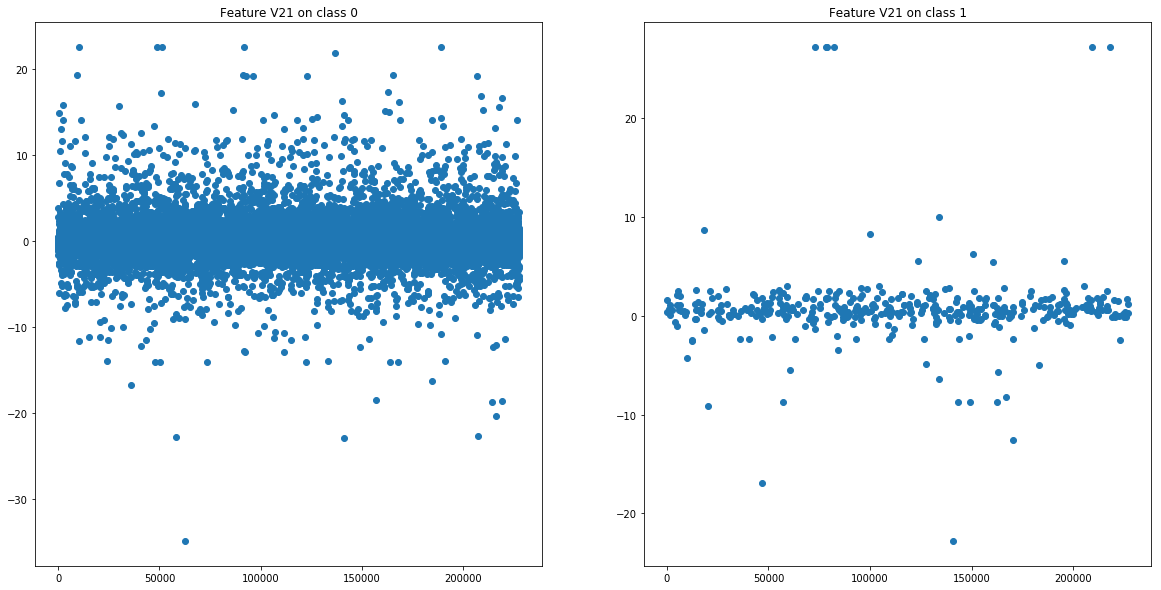

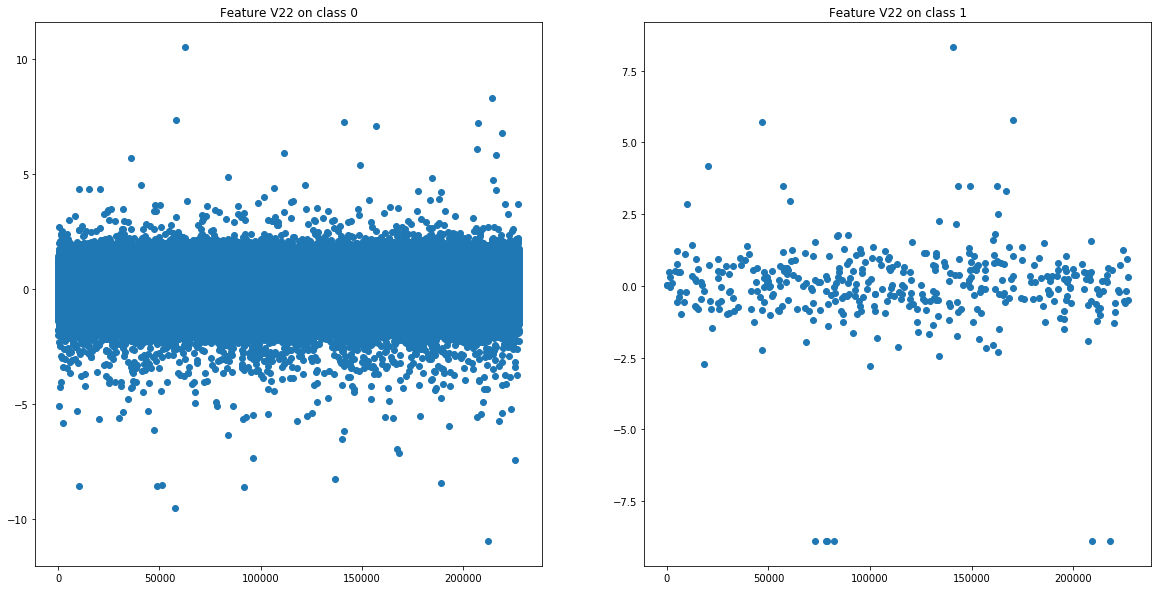

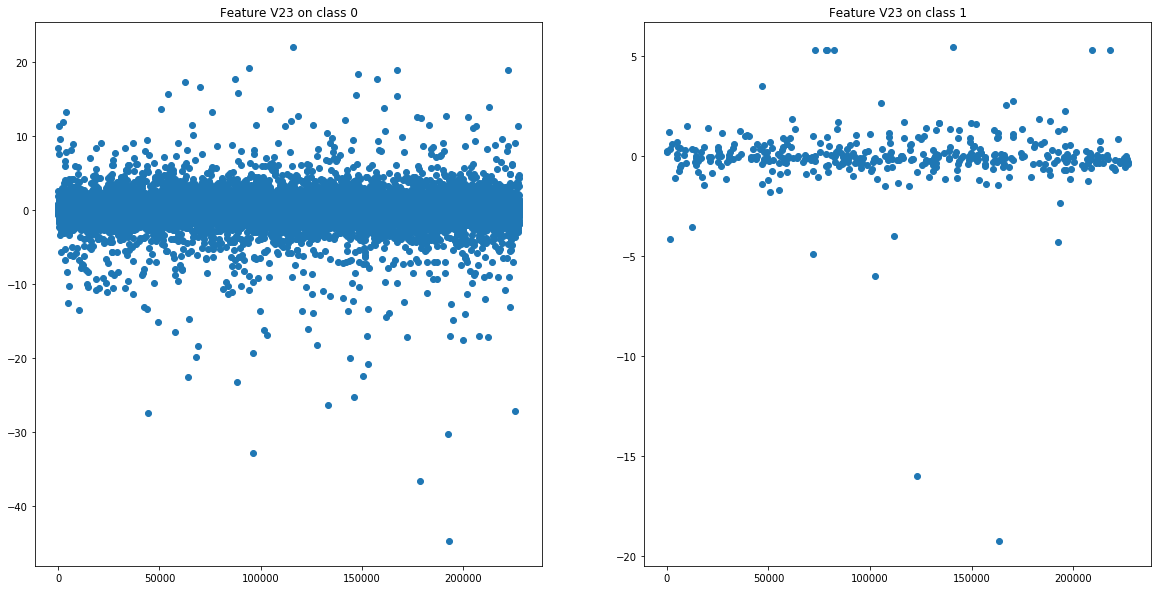

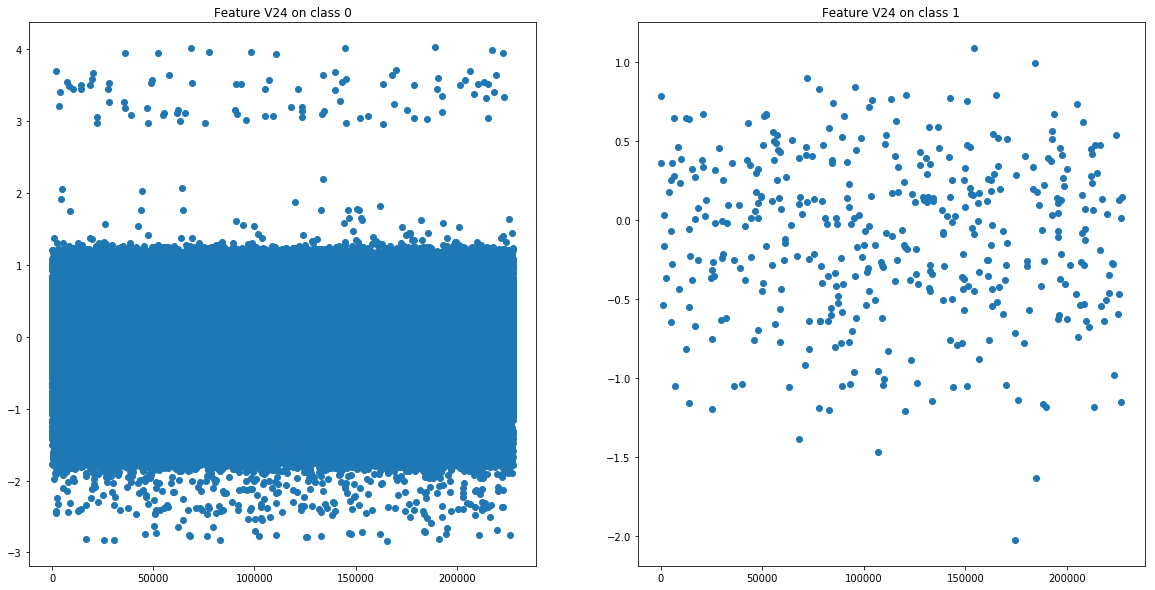

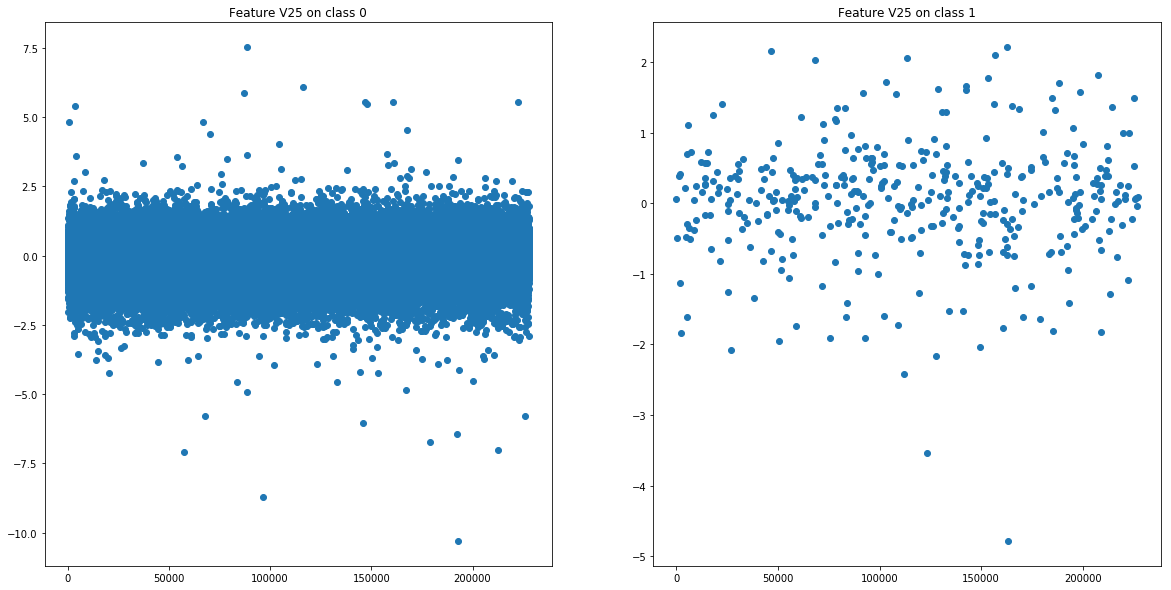

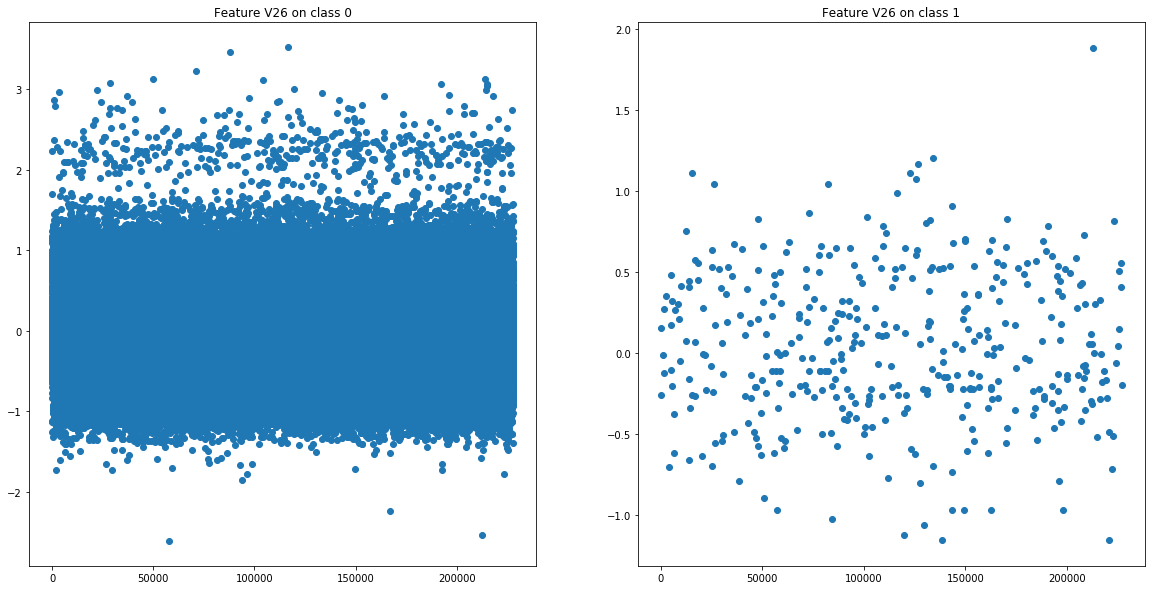

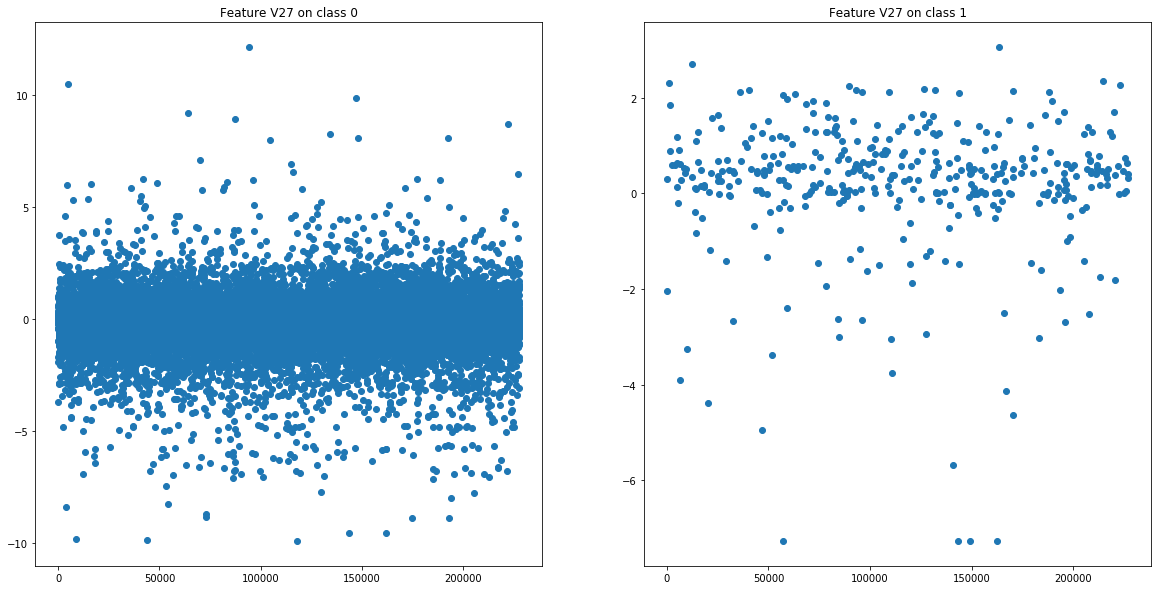

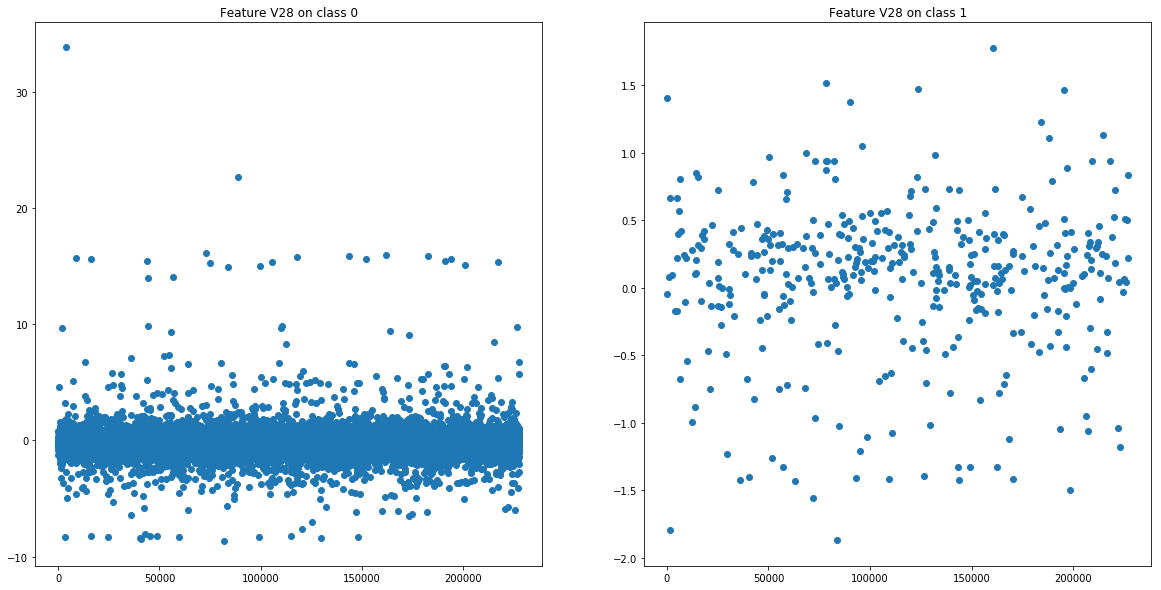

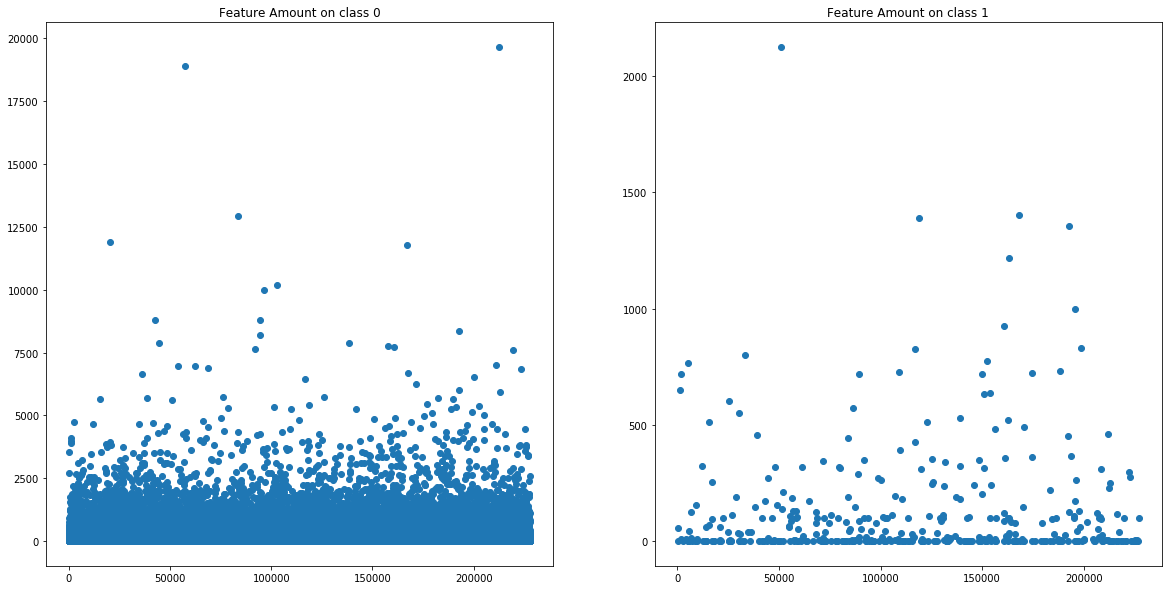

In [88]:
name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
for i in range(len(feature_names)):
    if i == 0 or i == len(feature_names)-1:
        continue
    fig = plt.figure(figsize=[20,10])
    for j in range(len(name_of_class)):
        y_raw = data_set.iloc[class_ix[name_of_class[j]],i]
        x = data_ix[name_of_class[j]]
        position = int('1{0}{1}'.format(len(name_of_class),j+1))
        ax = fig.add_subplot(position)
        ax.scatter(x, y_raw)
        ax.set_title('Feature {0} on class {1}'.format(feature_names[i], name_of_class[j]))
    plt.show()
    del fig

### Clean Outlier

As we can see from the figures above, there are some values that's way lower or higher than the average data. This may lead to outlier problem. There are some techniques we can use, such as:
* Winsorize
* Tukey's method
* Minkowski error
* Uni- and multi-variate analysis

Since this is the init of the project, we will use Winsorize technique as will the other techniques later. Let's set the percentile value to be 5%.

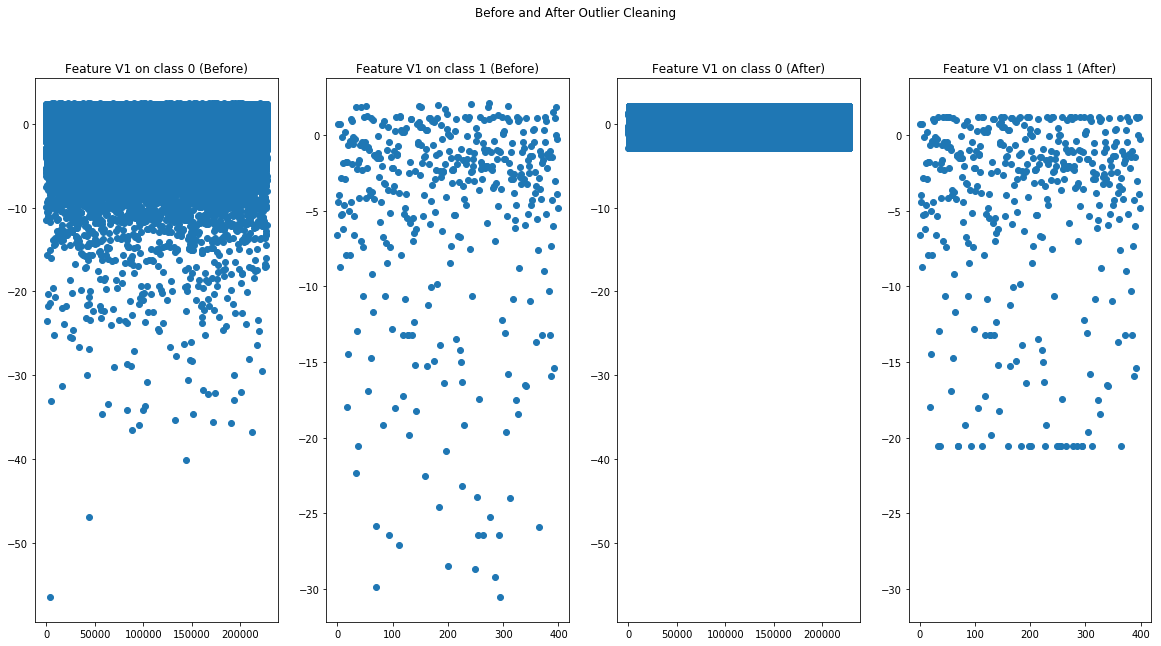

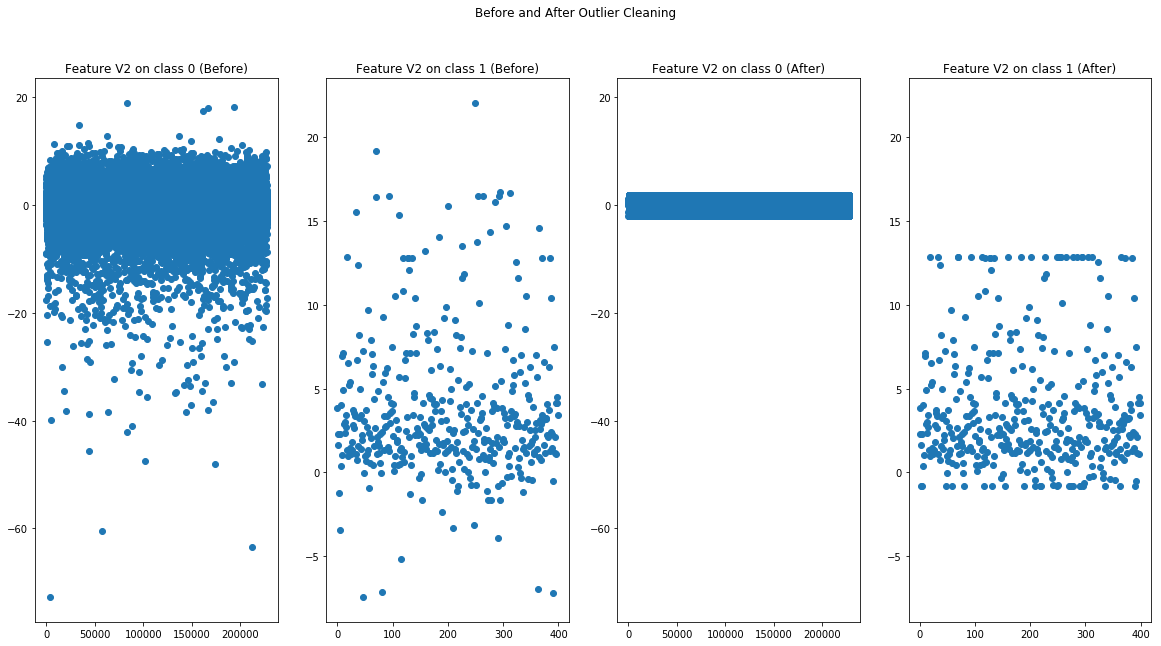

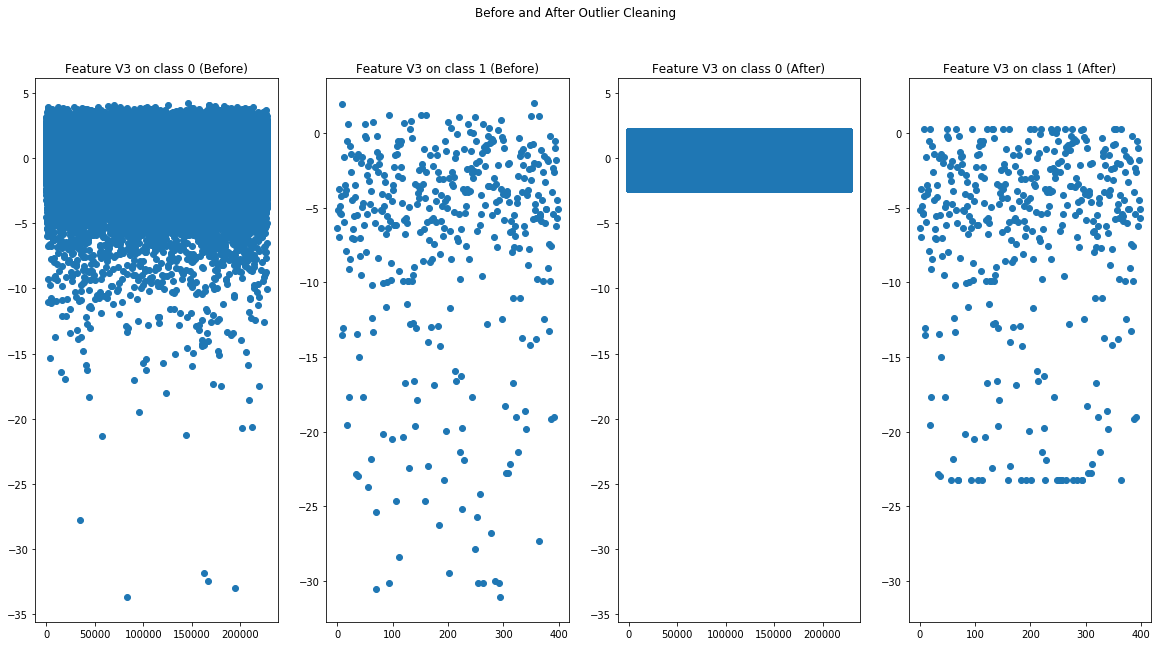

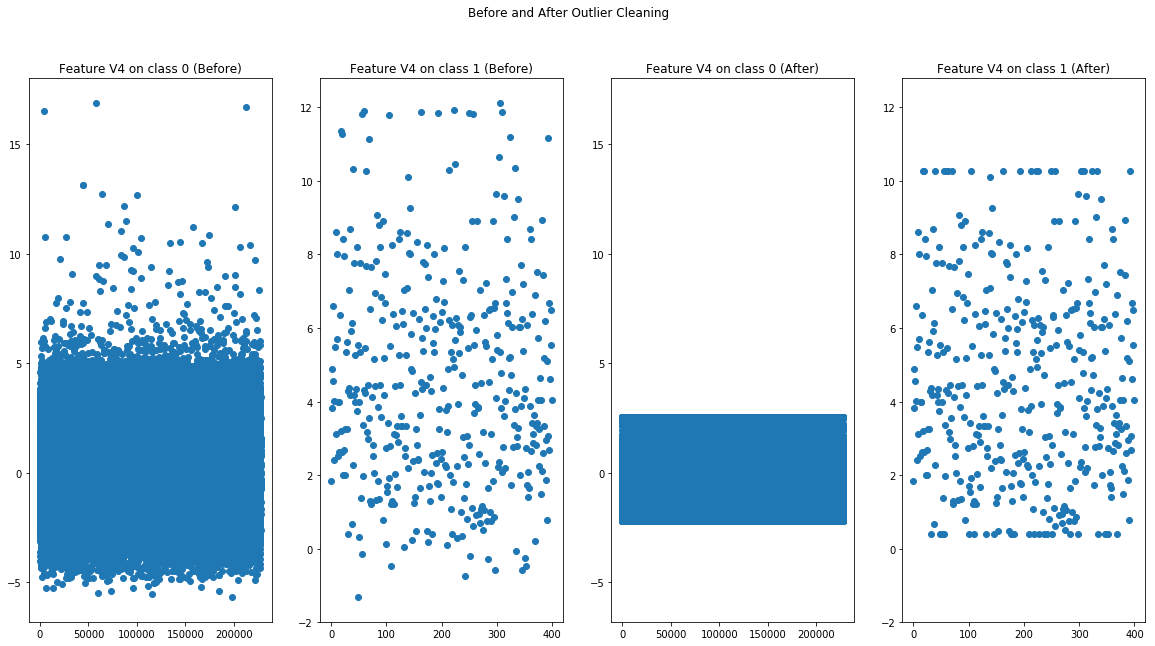

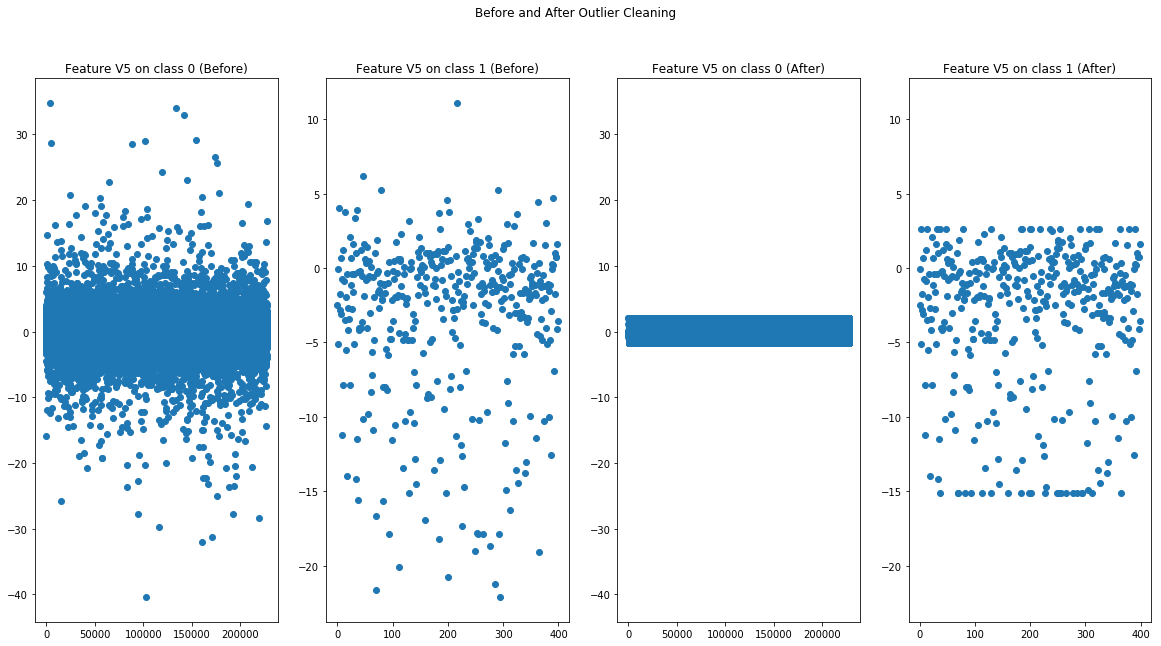

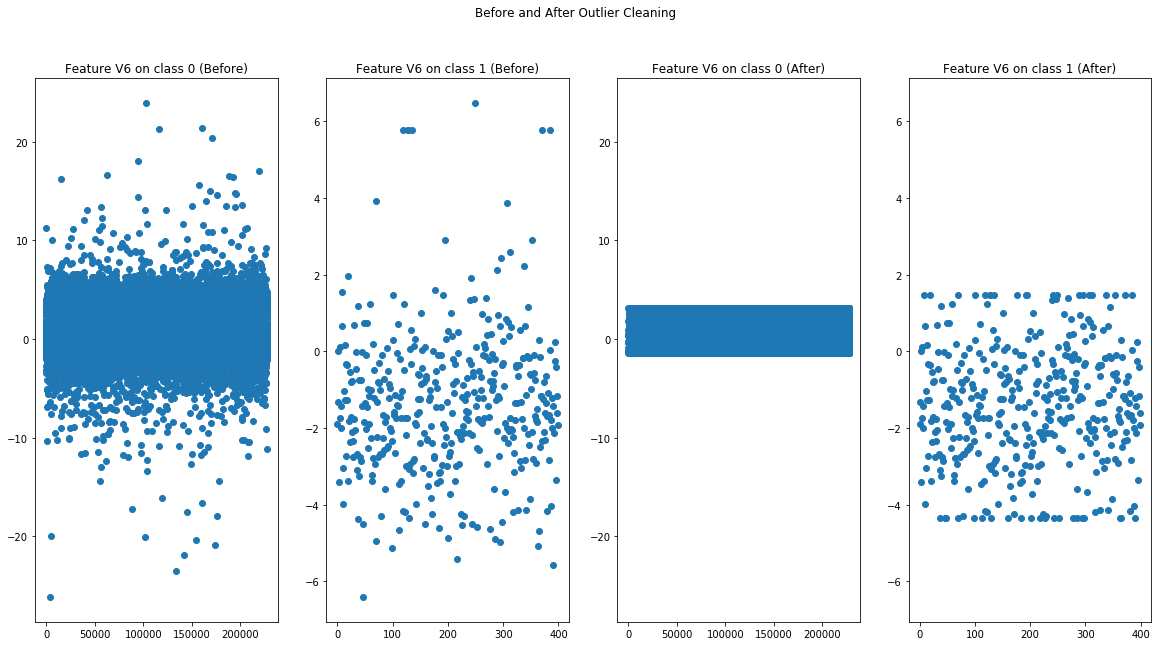

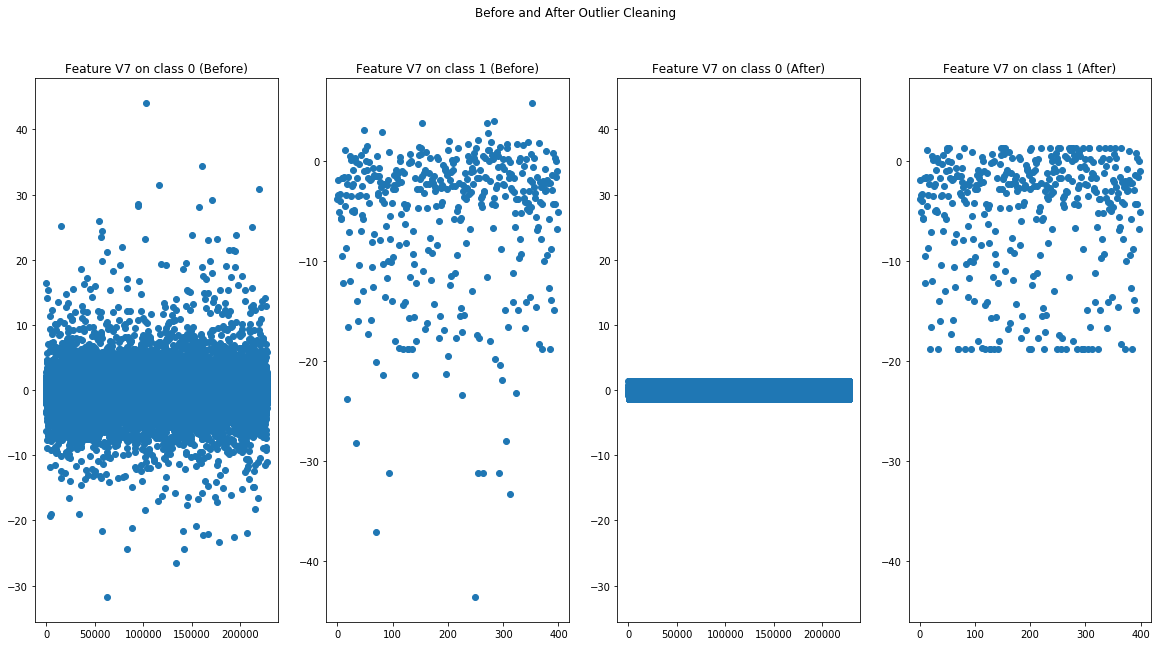

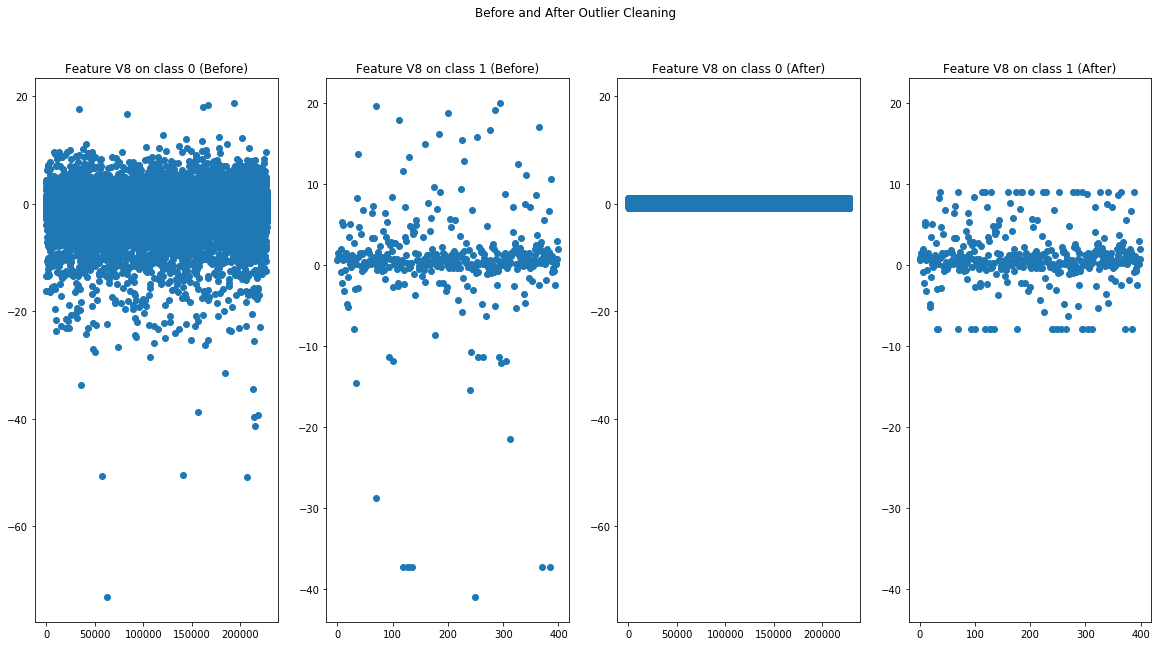

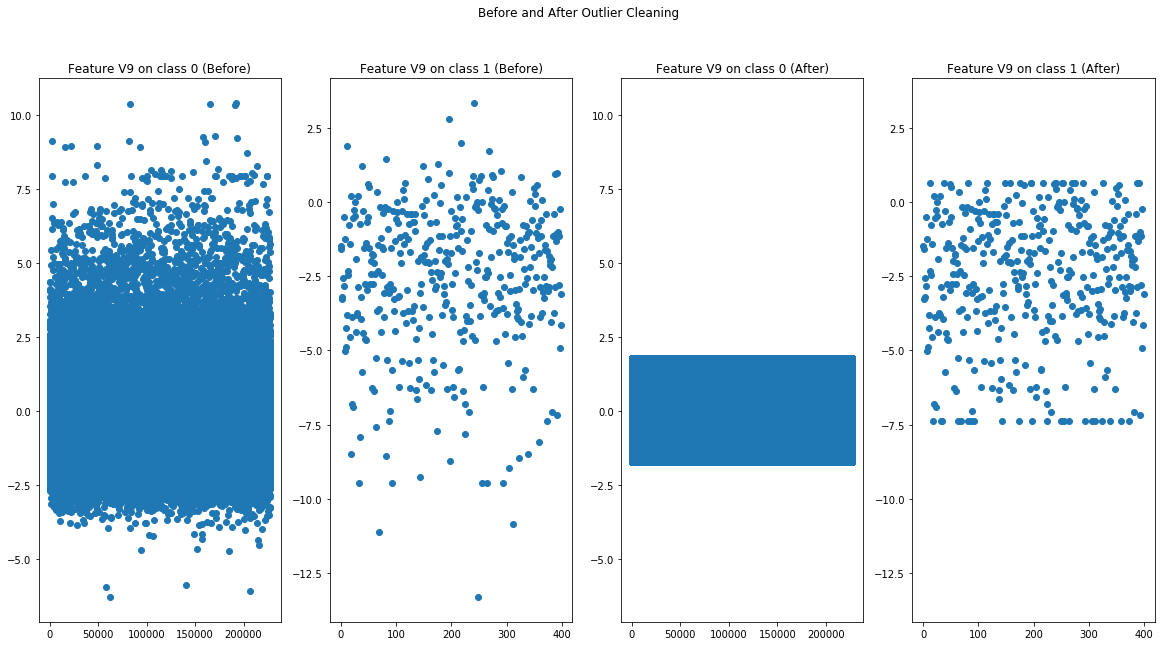

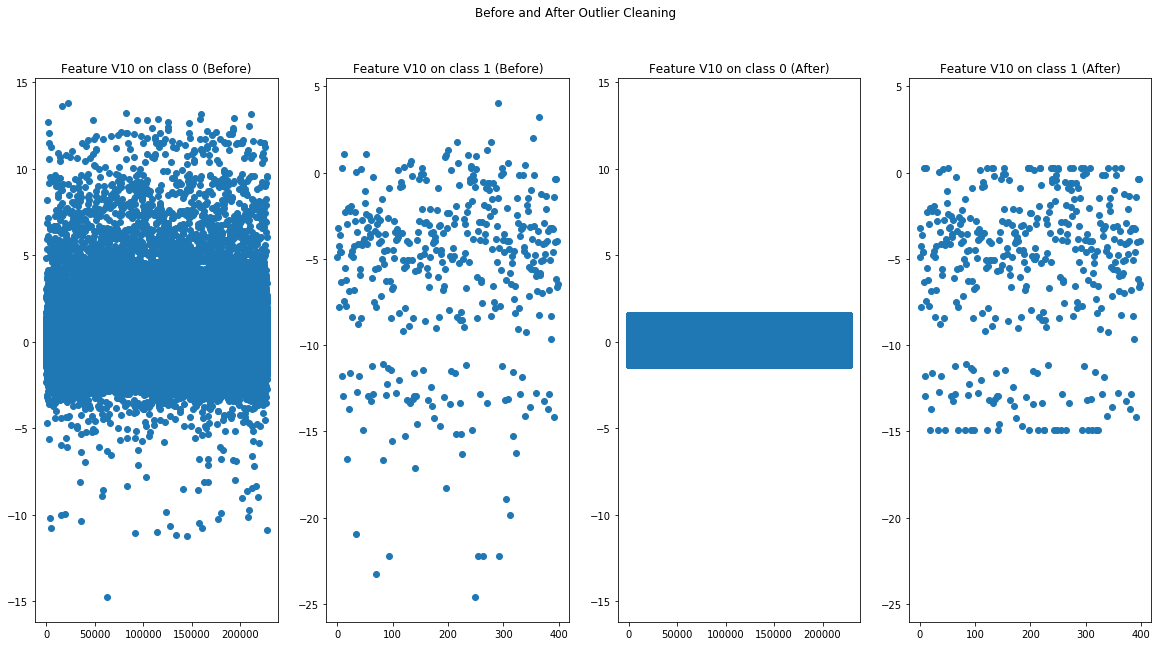

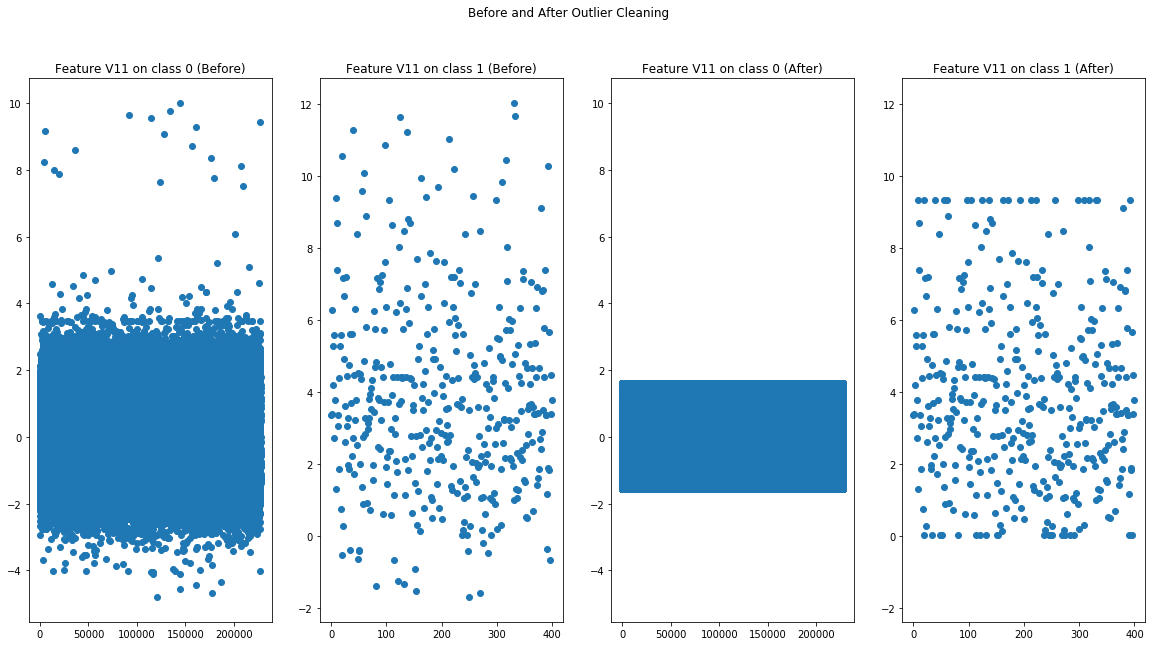

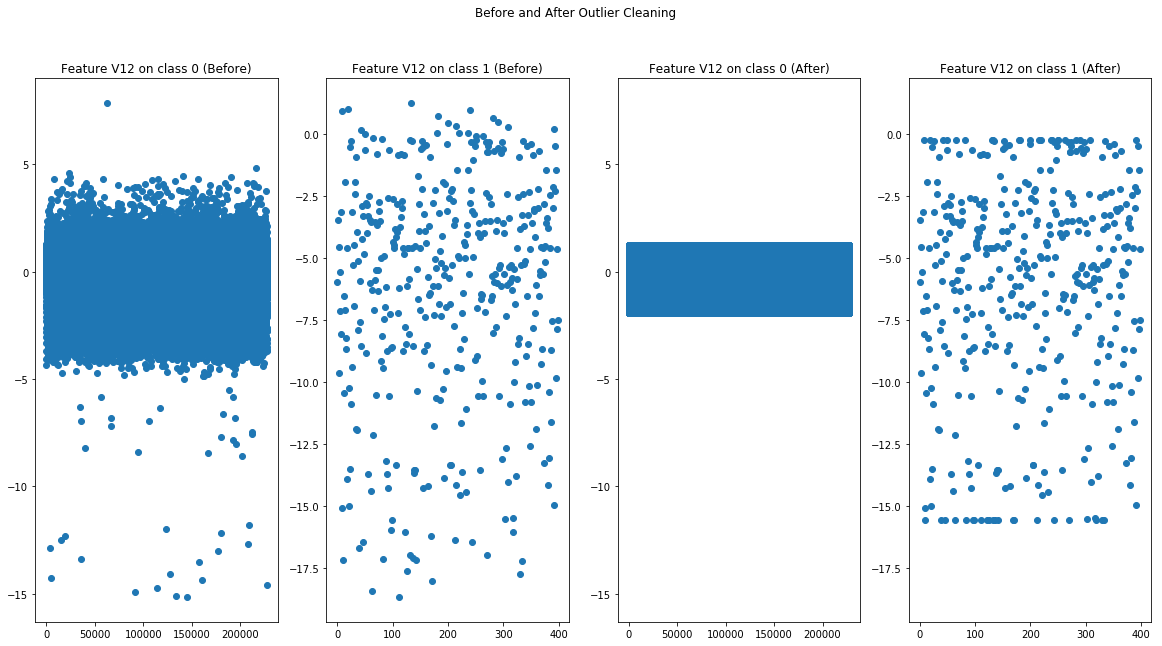

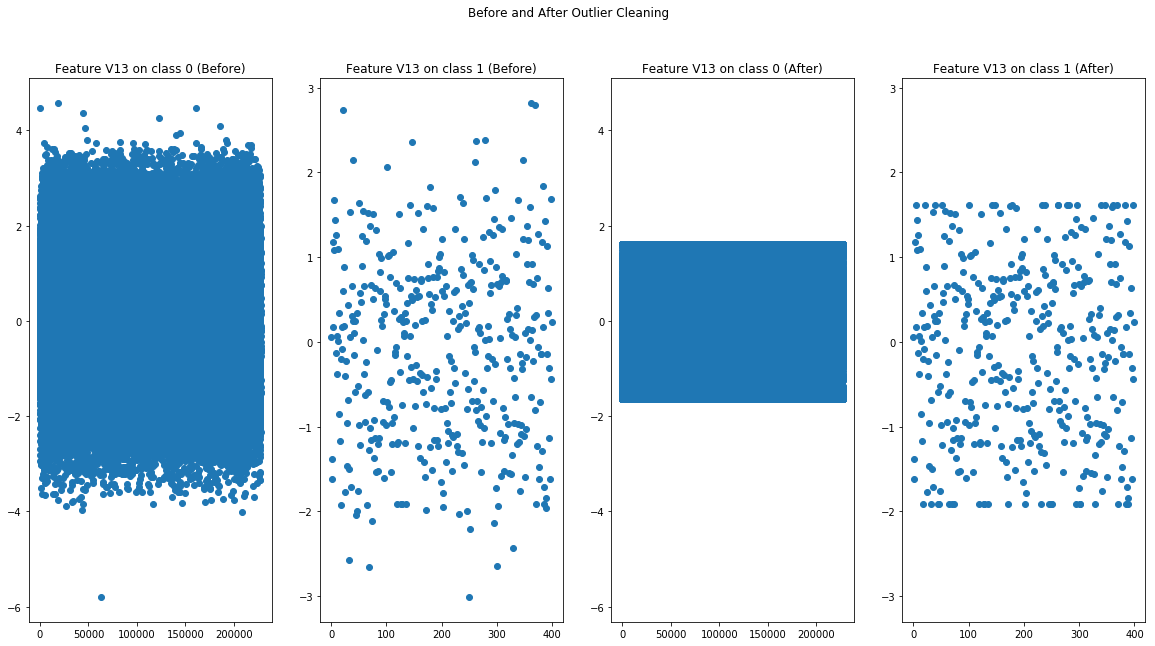

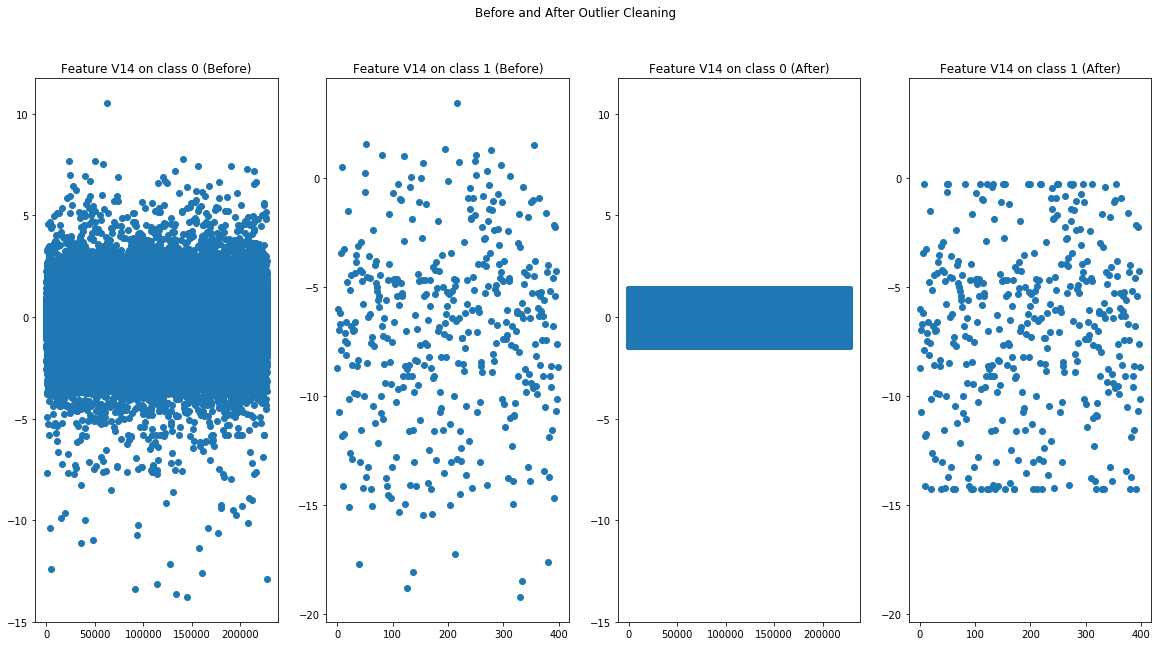

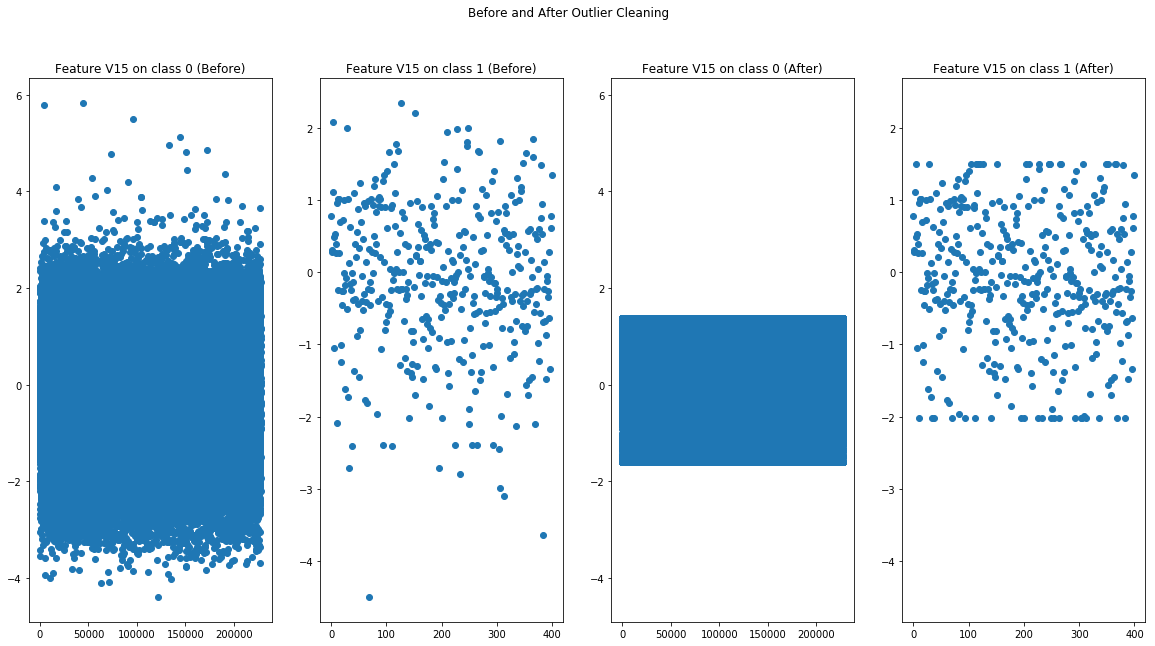

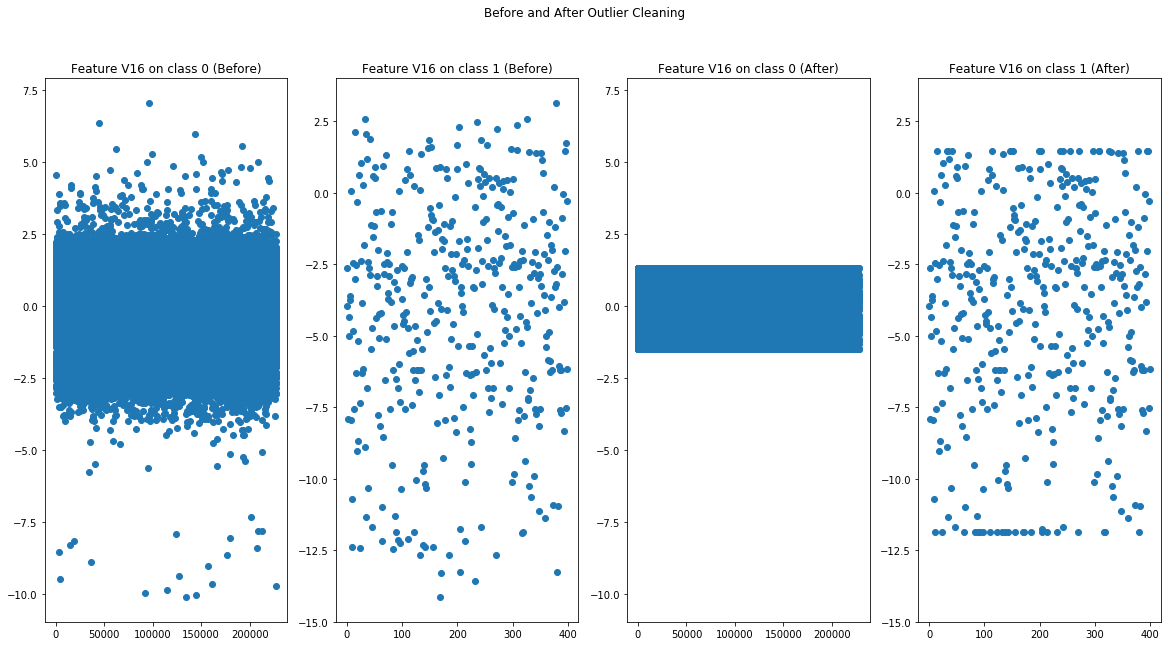

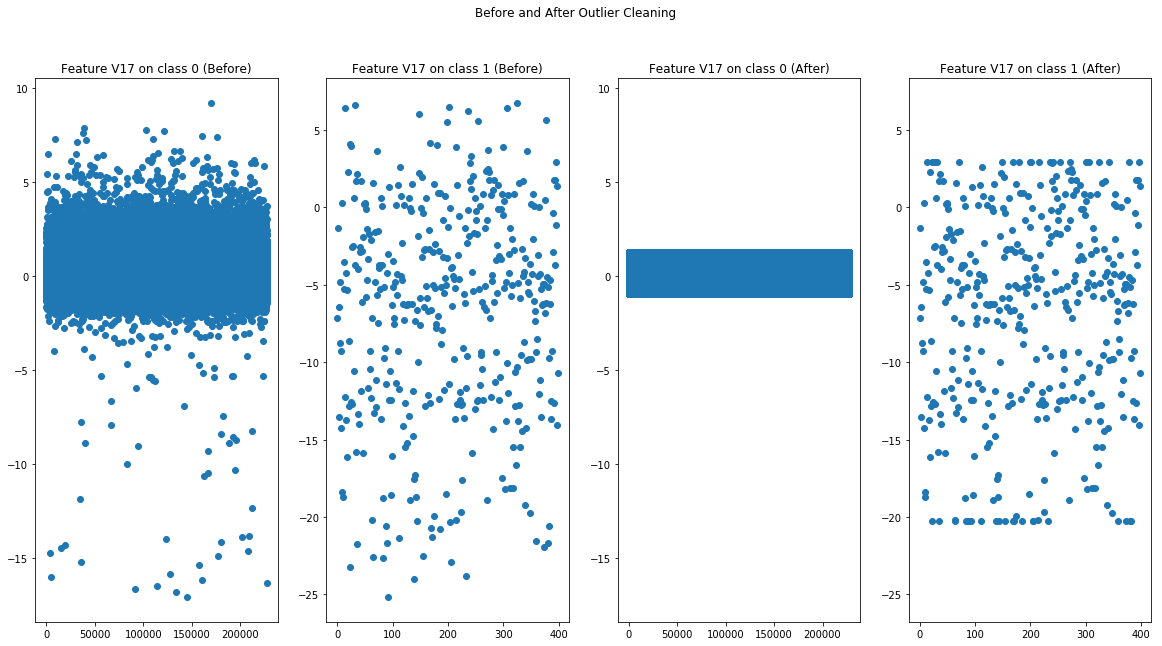

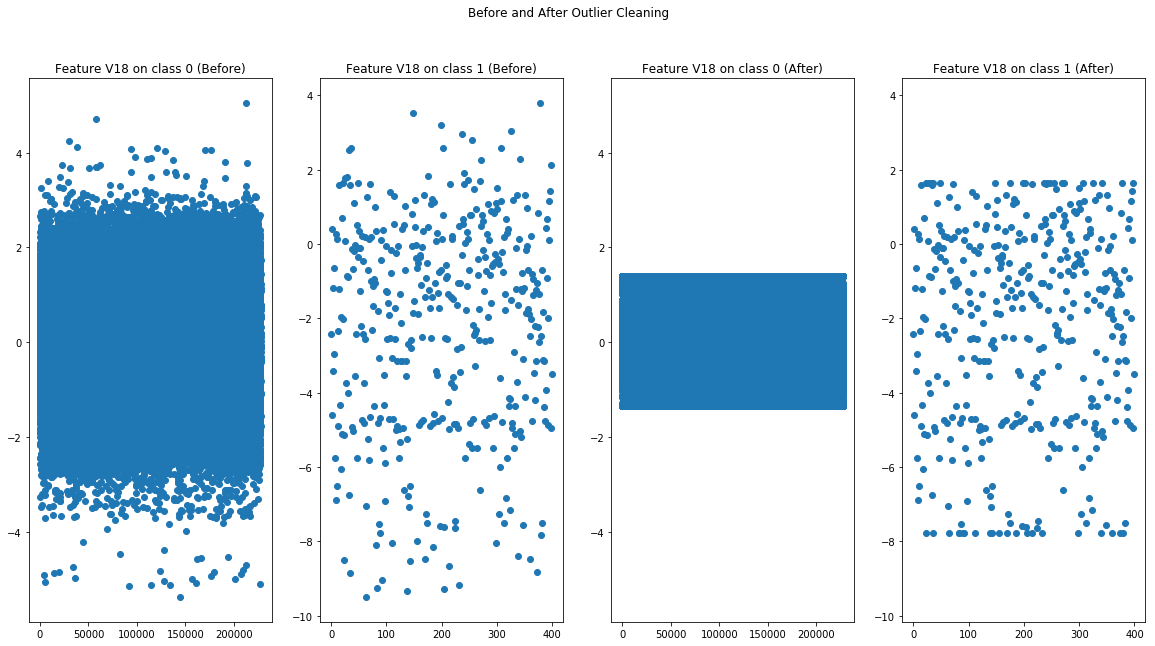

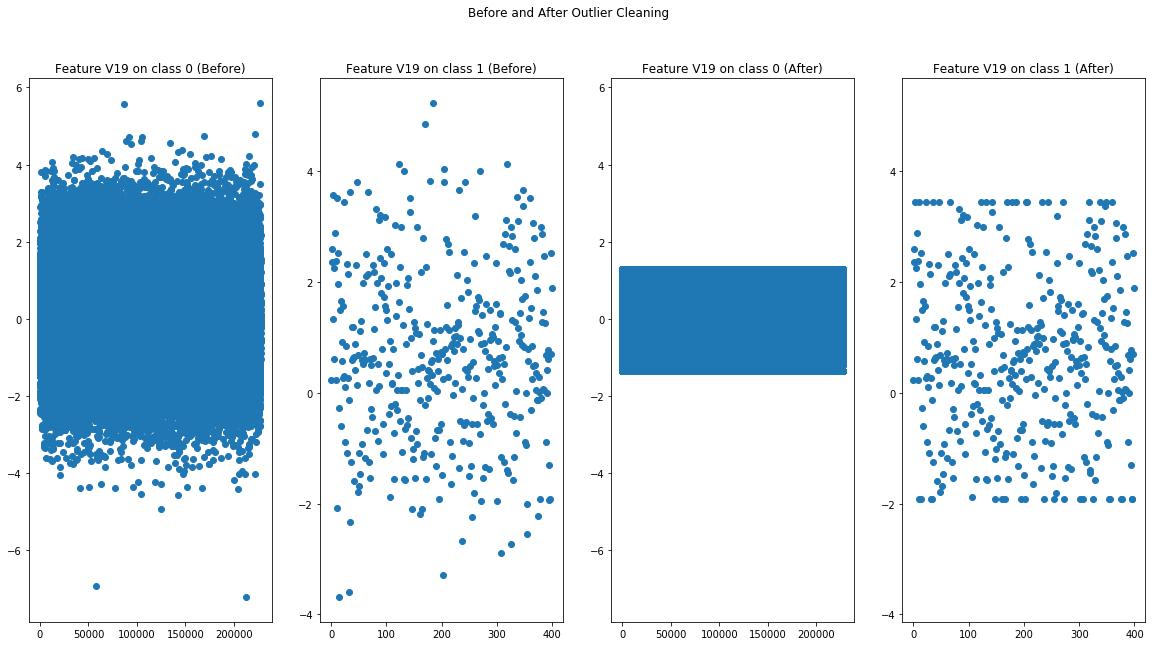

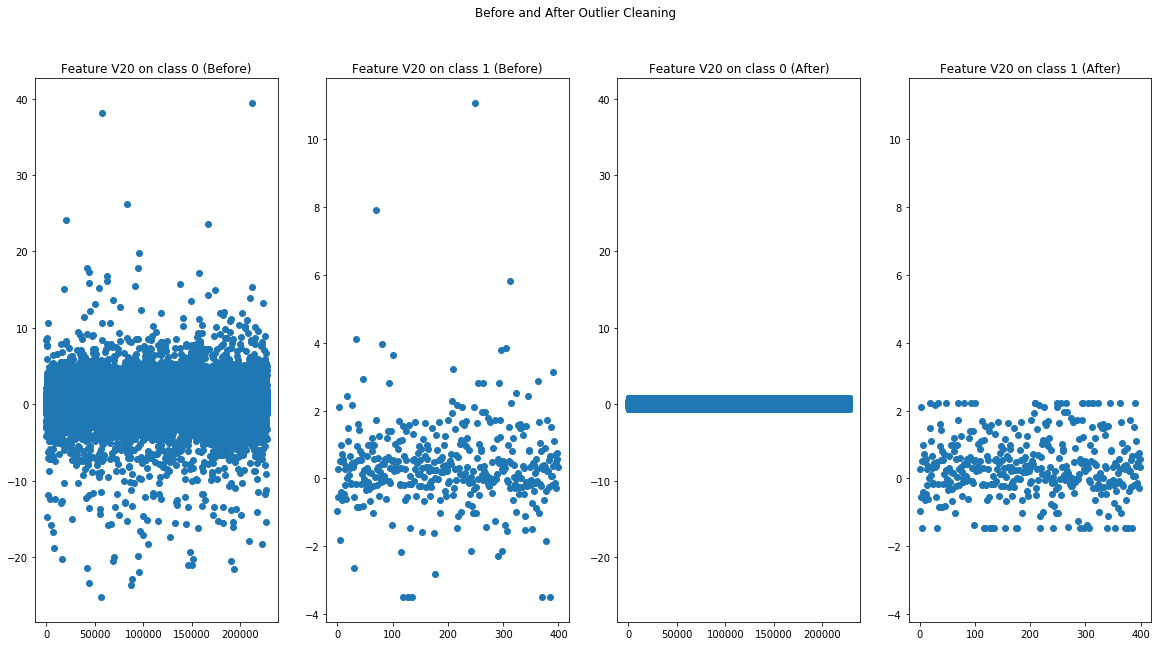

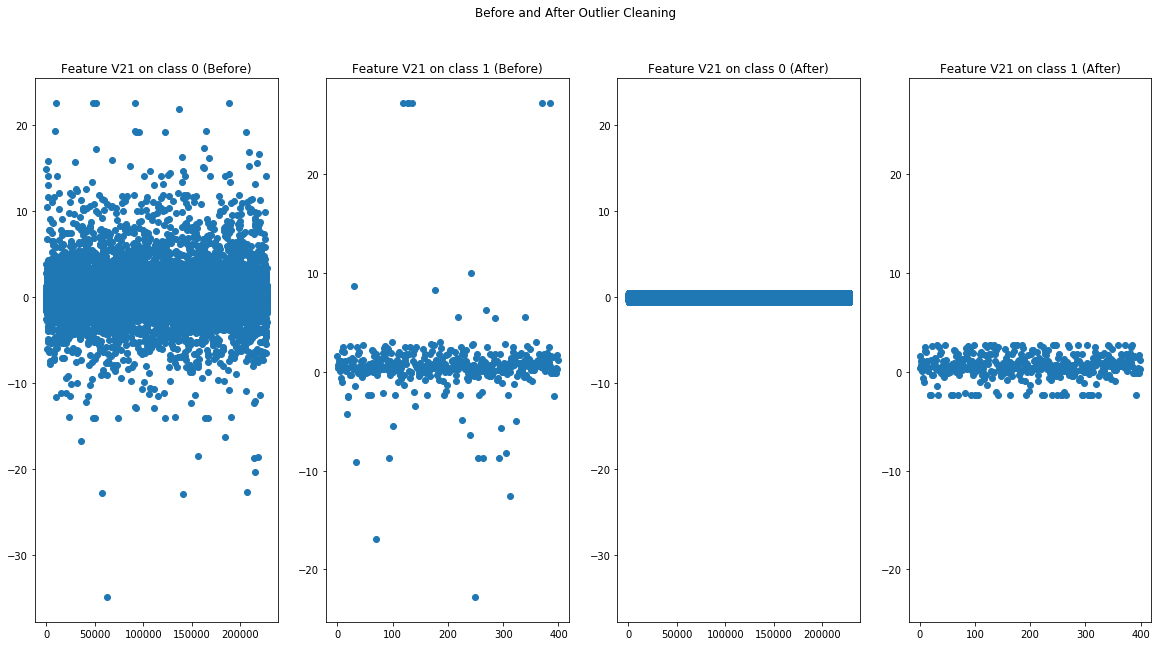

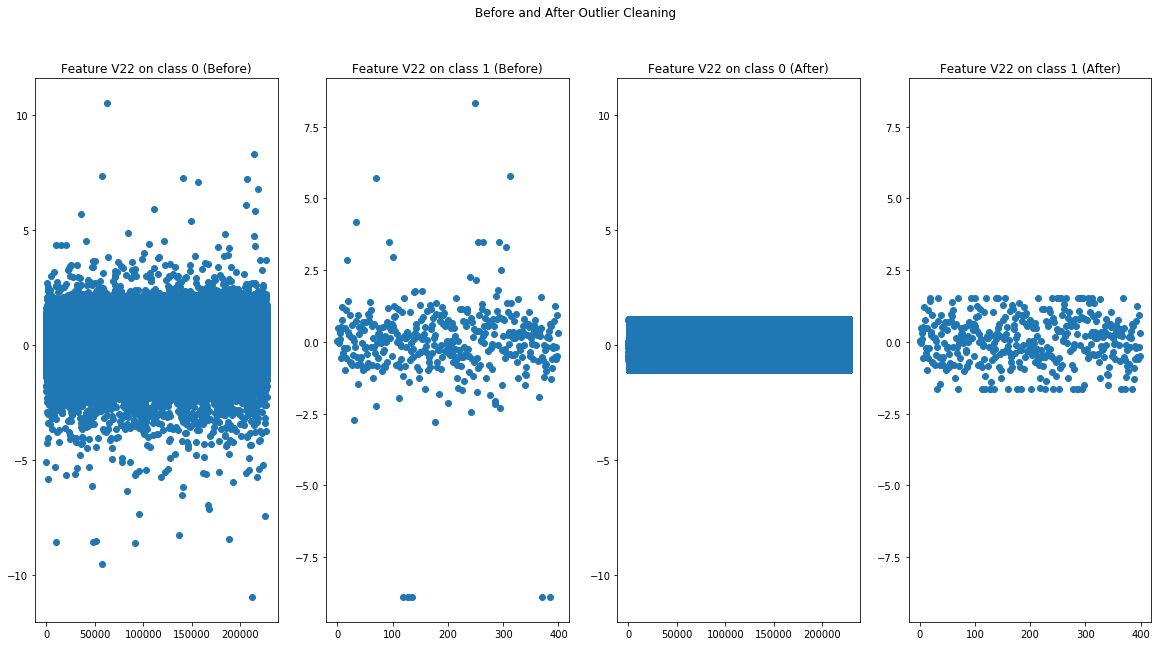

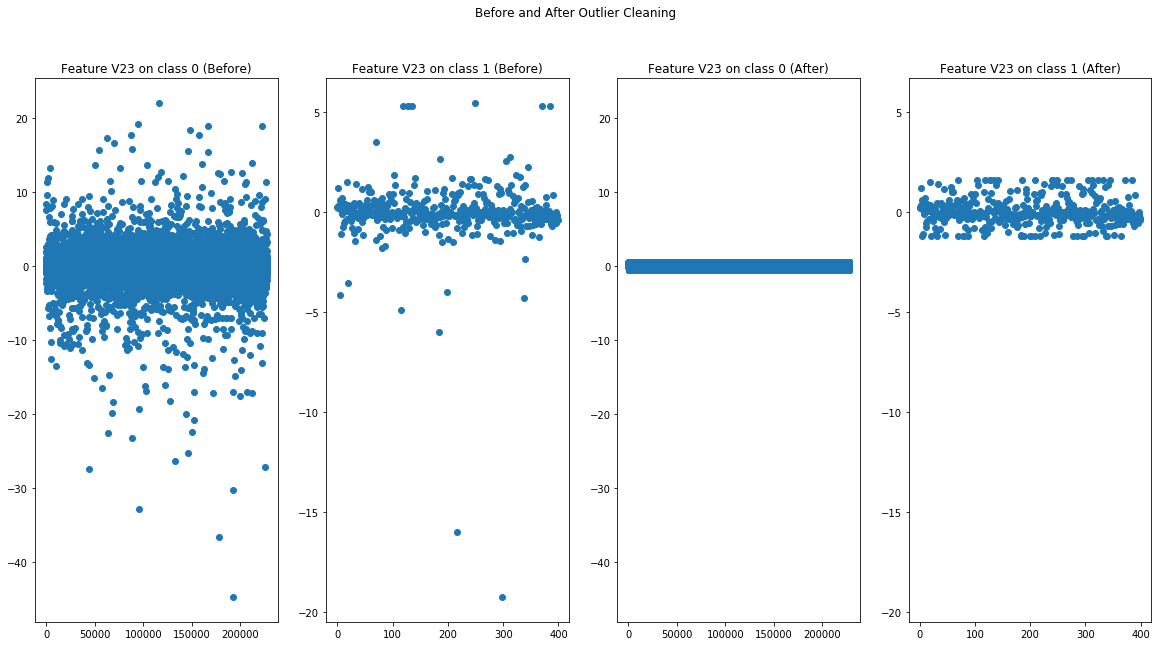

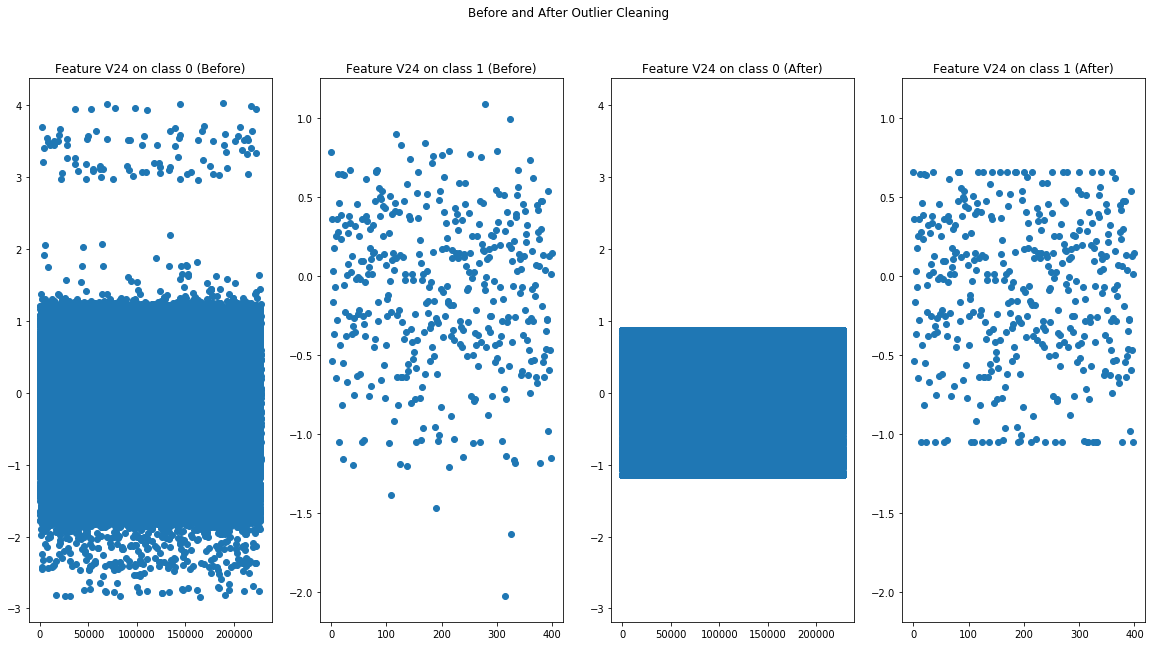

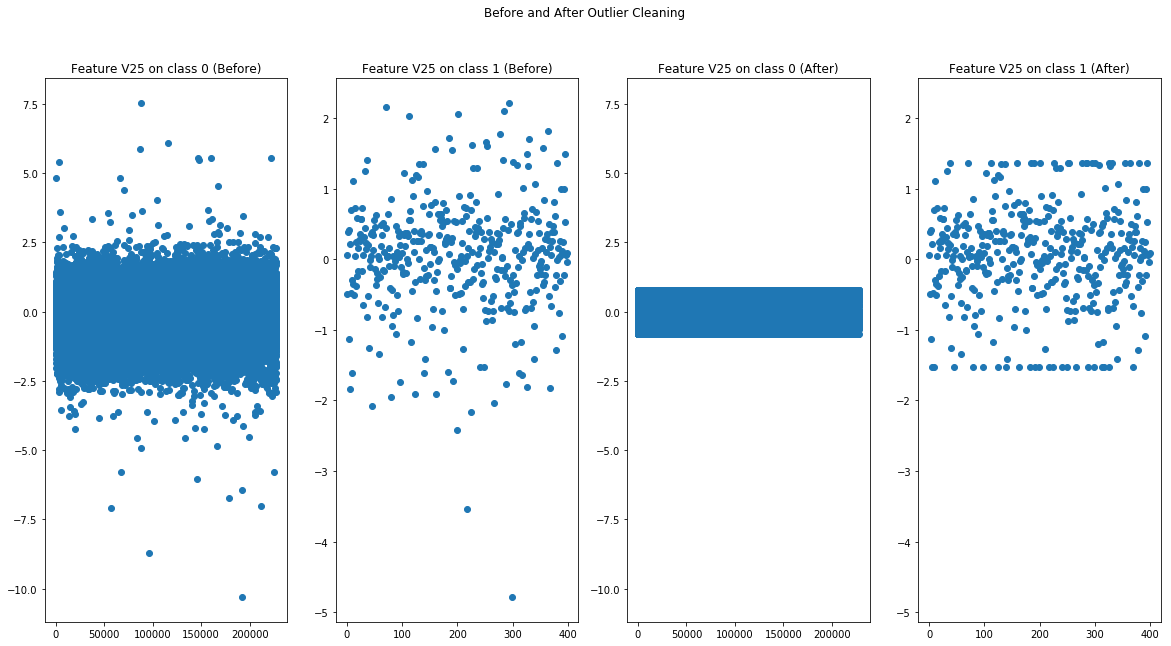

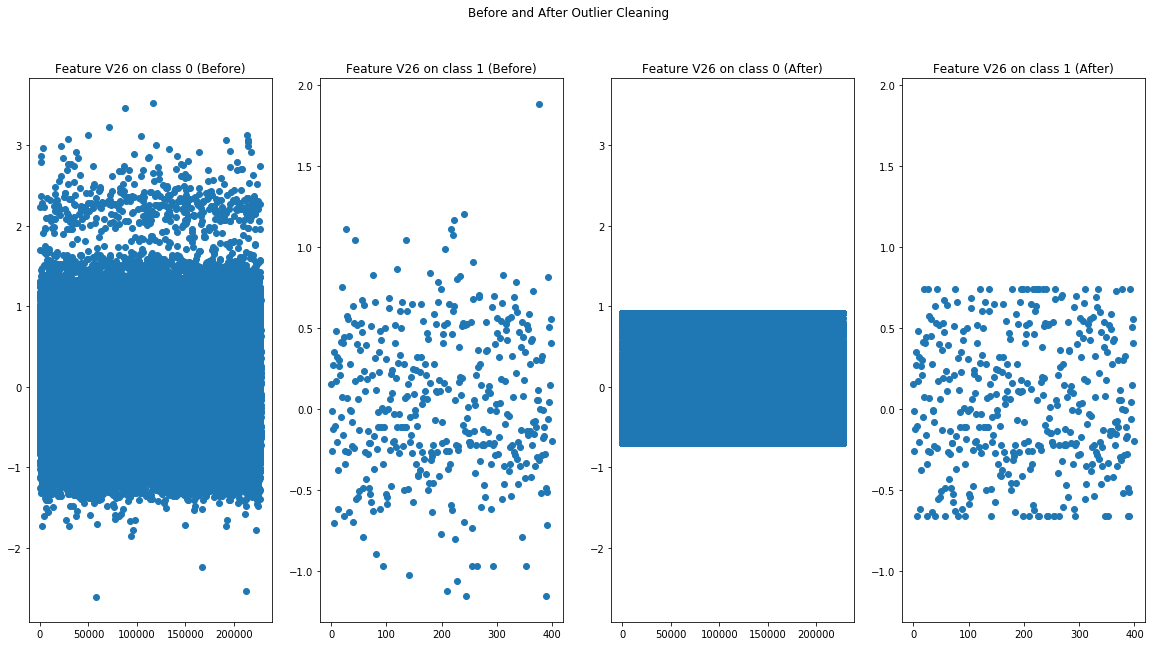

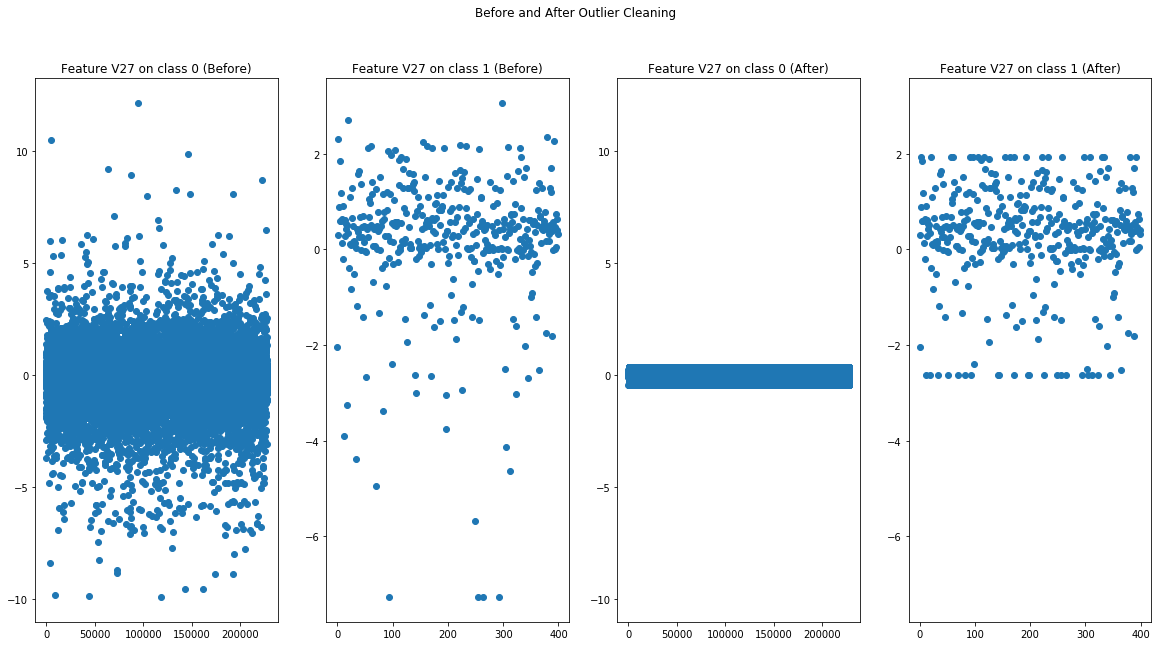

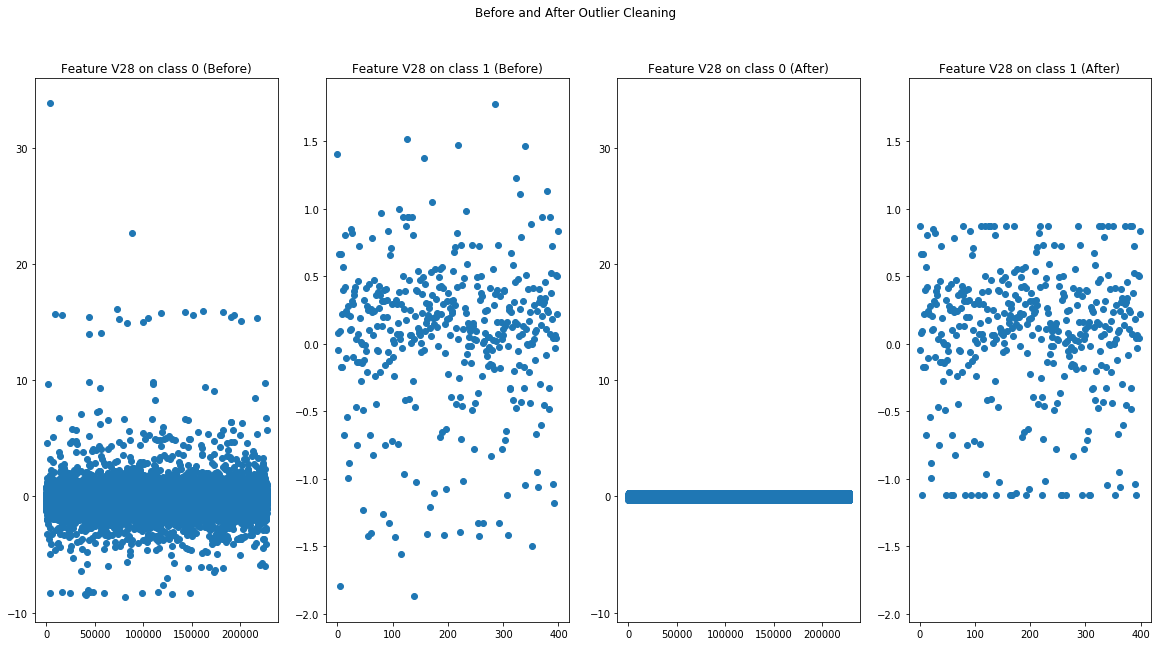

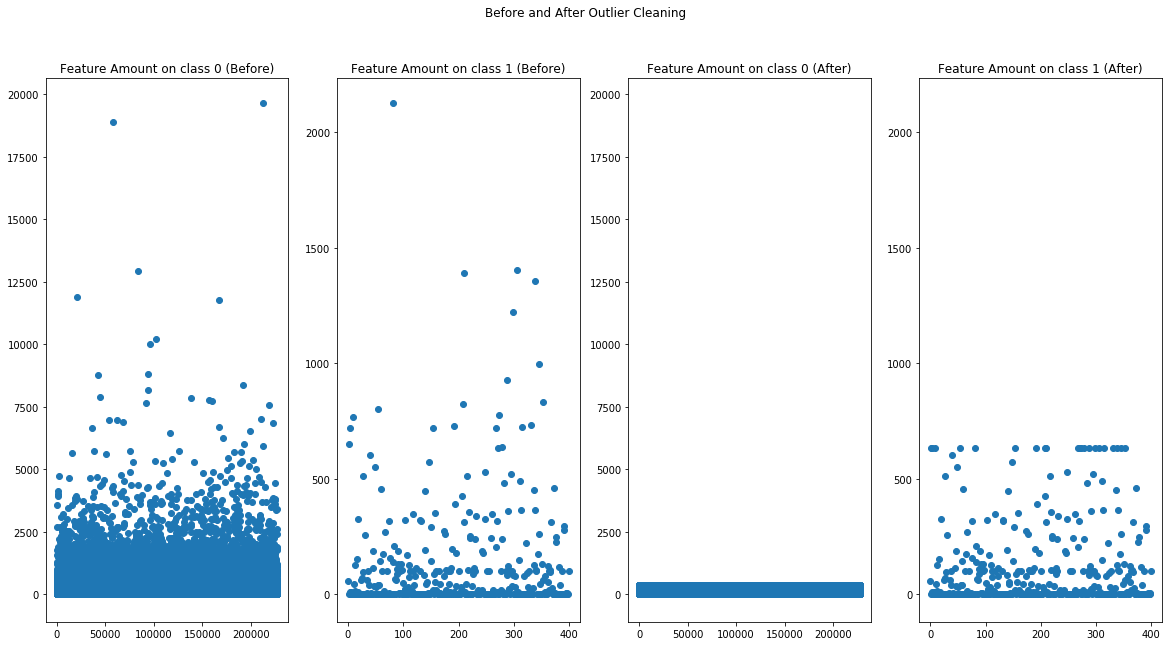

In [89]:
name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(class_ix[name_of_class[i]]))]

class_1_data = {}
select_ix = [True]*len(data_ix[0])
for i in range(len(feature_names)):
    if i == 0 or i == len(feature_names)-1:
        continue
    fig = plt.figure(figsize=[20,10])
    fig.suptitle('Before and After Outlier Cleaning')
    for j in range(len(name_of_class)):
        y_raw = data_set.iloc[class_ix[name_of_class[j]],i]
        x = data_ix[name_of_class[j]]
        position = int('1{0}{1}'.format(len(name_of_class)*2,j+1))
        ax0 = fig.add_subplot(position)
        ax0.scatter(x, y_raw)
        ax0.set_title('Feature {0} on class {1} (Before)'.format(feature_names[i], name_of_class[j]))
    
        y_cleaned = scipy.stats.mstats.winsorize(y_raw, limits = outlier_percentile)
        position = int('1{0}{1}'.format(len(name_of_class)*2,j+1+len(name_of_class)))
        ax1 = fig.add_subplot(position, sharey = ax0)
        ax1.scatter(x, y_cleaned)
        ax1.set_title('Feature {0} on class {1} (After)'.format(feature_names[i], name_of_class[j]))
        
        if j == 0:
            y_compare = y_raw == y_cleaned
            select_ix &= y_compare
        else:
            class_1_data[feature_names[i]] = y_cleaned
    plt.show()
    del fig
class_0_ix = [class_ix[name_of_class[0]][k] for k in range(len(select_ix)) if select_ix.iloc[k]]
class_0_data = data_set.iloc[class_0_ix,:]

temp_class_1_data = pd.DataFrame(data_set.iloc[class_ix[name_of_class[1]]])
for i in class_1_data:
    temp_class_1_data[i] = class_1_data[i]
data_set_undersampled = class_0_data.append(temp_class_1_data, ignore_index=True).dropna().reset_index()
del class_0_data, class_0_ix, temp_class_1_data

If we look closely at the code above, notice that I deleted some instances from the *data set*. The instances I deleted area the one considered as outlier on instances with class `0`. The reason for this is because the data contains imbalanced class with class `0` is far higher in number than class `1`. This problem will be solved at the later part. But before that, let's draw the data before and after outlier cleaning to see the number of instance for each class.

### Imbalanced class

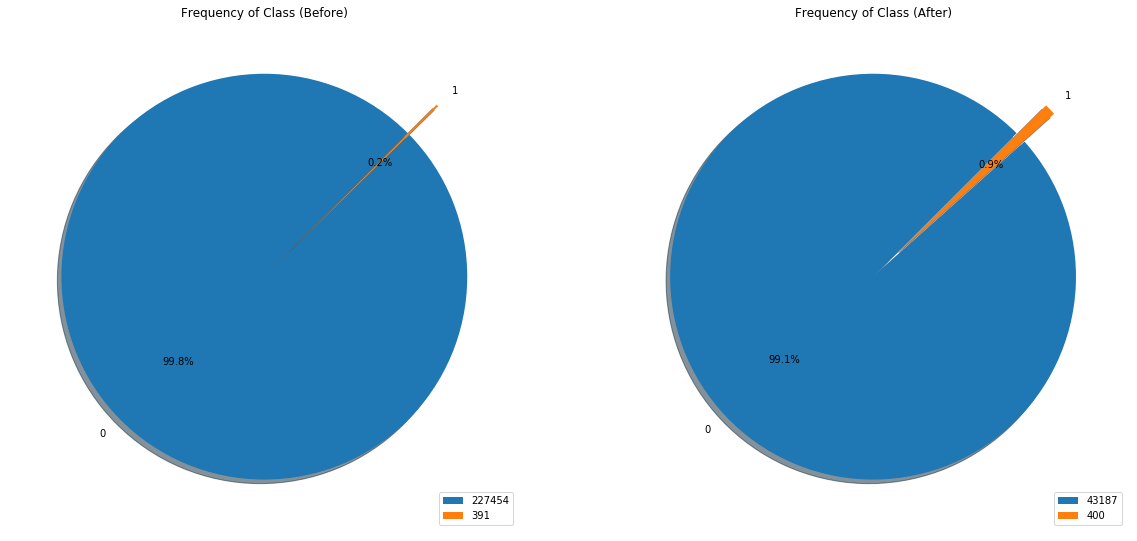

In [100]:
name_of_class_before, number_of_class_before = np.unique(data_set.iloc[:,-1], return_counts = True)
size_before = np.array(number_of_class_before, dtype = float) / np.sum(number_of_class_before)
explode_before = (number_of_class_before == number_of_class_before.min()) * 0.2

name_of_class_after, number_of_class_after = np.unique(data_set_undersampled.iloc[:,-1], return_counts = True)
size_after = np.array(number_of_class_after, dtype = float) / np.sum(number_of_class_after)
explode_after = (number_of_class_after == number_of_class_after.min()) * 0.2

# the_grid = GridSpec(2, 2)
# plt.subplot(the_grid[0, 0], aspect=1)
# plt.pie(size_before, explode = explode_before, labels = name_of_class_before, autopct='%1.1f%%',
#         shadow=True, startangle = 45)
# plt.subplot(the_grid[0, 1], aspect=1)
# plt.pie(size_after, explode = explode_after, labels = name_of_class_after, autopct='%1.1f%%',
#         shadow=True, startangle = 45)

fig = plt.figure(figsize=[20,10])
ax0 = fig.add_subplot('121')
ax0.set_title('Frequency of Class (Before)')
ax0.pie(size_before, explode = explode_before, labels = name_of_class_before, autopct = '%1.1f%%',
      shadow = True, startangle = 45)
ax0.legend(number_of_class_before, loc = 'lower right')

ax1 = fig.add_subplot('122')
ax1.set_title('Frequency of Class (After)')
ax1.pie(size_after, explode = explode_before, labels = name_of_class_after, autopct = '%1.1f%%',
      shadow = True, startangle = 45)
ax1.legend(number_of_class_after, loc = 'lower right')

#_, ax1 = plt.subplots()
#ax1.set_title('Frequency of Class')
#ax1.pie(size, explode = explode, labels = name_of_class, autopct = '%1.1f%%',
#        shadow = True, startangle = 45)
#ax1.legend(number_of_class, loc = 'lower right')
#
plt.show()

As we can see, the number of class in dataset is two classes, named class `0` (with frequency of 284315) and class `1` (with frequency of 492).<br>
This clearly shows that the dataset contains imbalanced class problem.

There are some possible solutions we can use,
> 1. Collect more data
> 2. Under sampling
> 3. Over sampling
> 4. Combination of under and over sampling